In [9]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/NUS/GNNs/NeuralExecutionOfGraphAlgorithms/'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/NUS/GNNs/NeuralExecutionOfGraphAlgorithms/
/content/gdrive/MyDrive/NUS/GNNs/NeuralExecutionOfGraphAlgorithms


In [4]:
# Install required packages.
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import torch
import torch_geometric as tg
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
import math
import pickle
import copy

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU instead.")

Using Tesla T4


# Data explanation





### Ladder graphs


Ladder graph is a type of graph in which nodes are arranged in a ladder-like form with two vertical columns of nodes and rungs connecting the nodes in the two columns. It has 2n vertices and 3n-2 edges, where n is the number of rungs. They are bipartite and have a Hamiltonian cycle for even n. 



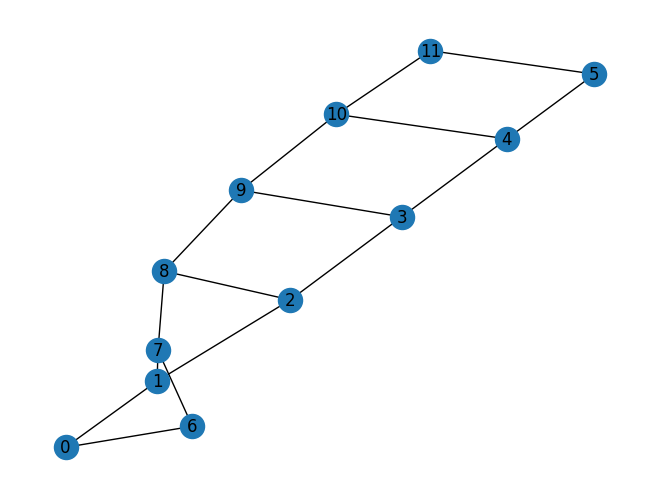

In [ ]:
n = 6 # number of rungs

# create ladder graph
G = nx.ladder_graph(n)

# draw graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

plt.show()

In [ ]:
# adj shows edges and edge attribues lists
G.adj

AdjacencyView({0: {1: {}, 6: {}}, 1: {0: {}, 2: {}, 7: {}}, 2: {1: {}, 3: {}, 8: {}}, 3: {2: {}, 4: {}, 9: {}}, 4: {3: {}, 5: {}, 10: {}}, 5: {4: {}, 11: {}}, 6: {7: {}, 0: {}}, 7: {6: {}, 8: {}, 1: {}}, 8: {7: {}, 9: {}, 2: {}}, 9: {8: {}, 10: {}, 3: {}}, 10: {9: {}, 11: {}, 4: {}}, 11: {10: {}, 5: {}}})

In [ ]:
# list of nodes
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

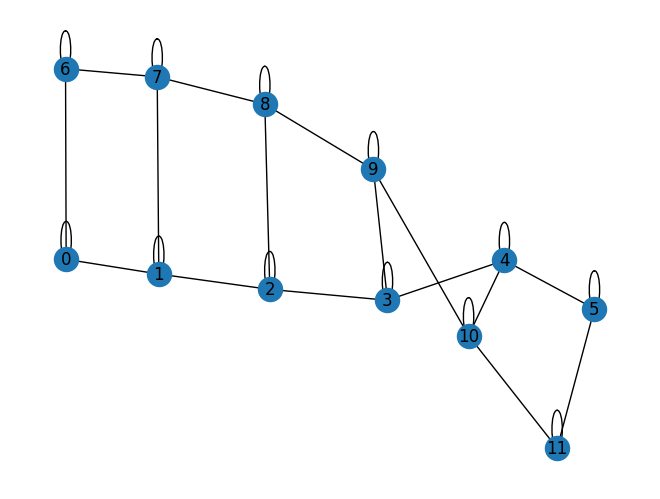

In [ ]:
# inserting a self-edge to every node in the graph
self_edges = [(node, node) for node in G.nodes()]
G.add_edges_from(self_edges)

nx.draw(G, with_labels=True)
plt.show()

In [ ]:
# attaching real-valued wright to every edge, drawn uniformly from the range [0.2, 1]
for u, v in G.edges():
  G[u][v]['weight'] = random.uniform(0.2, 1)

for u, v, w in G.edges.data('weight'):
  print(f"({u}, {v}): {w}")

(0, 1): 0.798455024296896
(0, 6): 0.6385315542131218
(0, 0): 0.3406305934302206
(1, 2): 0.21935456496910088
(1, 7): 0.5426546583168661
(1, 1): 0.21564397335018104
(2, 3): 0.6402244118571057
(2, 8): 0.5541386723325625
(2, 2): 0.36386519441569143
(3, 4): 0.24575916741737533
(3, 9): 0.7621057439490402
(3, 3): 0.304976100016376
(4, 5): 0.20396674132619844
(4, 10): 0.7707354885521525
(4, 4): 0.413158528741687
(5, 11): 0.8857648832668694
(5, 5): 0.2402196671901452
(6, 7): 0.43569132311846037
(6, 6): 0.5603356528633807
(7, 8): 0.43421345916934756
(7, 7): 0.21701861342141726
(8, 9): 0.3801790632298683
(8, 8): 0.4325544260669958
(9, 10): 0.23908609279046084
(9, 9): 0.5688870737525711
(10, 11): 0.6655376636570394
(10, 10): 0.2355474710065928
(11, 11): 0.7587252822622095


In [ ]:
G.adj

AdjacencyView({0: {1: {'weight': 0.798455024296896}, 6: {'weight': 0.6385315542131218}, 0: {'weight': 0.3406305934302206}}, 1: {0: {'weight': 0.798455024296896}, 2: {'weight': 0.21935456496910088}, 7: {'weight': 0.5426546583168661}, 1: {'weight': 0.21564397335018104}}, 2: {1: {'weight': 0.21935456496910088}, 3: {'weight': 0.6402244118571057}, 8: {'weight': 0.5541386723325625}, 2: {'weight': 0.36386519441569143}}, 3: {2: {'weight': 0.6402244118571057}, 4: {'weight': 0.24575916741737533}, 9: {'weight': 0.7621057439490402}, 3: {'weight': 0.304976100016376}}, 4: {3: {'weight': 0.24575916741737533}, 5: {'weight': 0.20396674132619844}, 10: {'weight': 0.7707354885521525}, 4: {'weight': 0.413158528741687}}, 5: {4: {'weight': 0.20396674132619844}, 11: {'weight': 0.8857648832668694}, 5: {'weight': 0.2402196671901452}}, 6: {7: {'weight': 0.43569132311846037}, 0: {'weight': 0.6385315542131218}, 6: {'weight': 0.5603356528633807}}, 7: {6: {'weight': 0.43569132311846037}, 8: {'weight': 0.434213459169

### 2D grid graphs

2D grid graph is a a type of gtaph that is defined on a rectangular grid of vertices. Each vertix in the grid is connected to its four adjacent vertices (top, bottom, left, right) unless it lies on the boundary of the grid. If n is the number of rows, and m number of columns, it can formaly be defined as: 
- The vertex set V is the set of all ordered pairs (i, j) where 1 <= i <= n and 1 <= j <= m. 
- Two vertices (i, j) and (k, l) are adjacend in the graph if and only if abs(i - k) + abs(j - l) = 1.


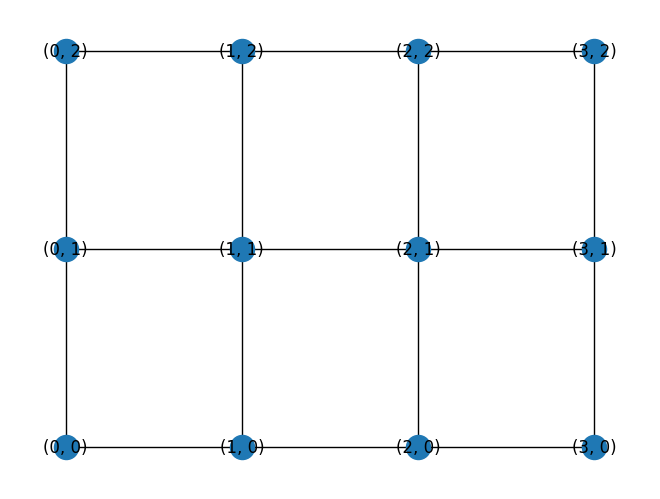

In [ ]:
n = 4 # number of rows
m = 3 # number of columns

# create 2d grid graph
G = nx.grid_2d_graph(n, m)

# draw graph
pos = {(i, j): (i, j) for i in range(n) for j in range(m)}
nx.draw(G, pos, with_labels=True)

plt.show()

In [ ]:
G.adj

AdjacencyView({(0, 0): {(1, 0): {}, (0, 1): {}}, (0, 1): {(1, 1): {}, (0, 0): {}, (0, 2): {}}, (0, 2): {(1, 2): {}, (0, 1): {}}, (1, 0): {(0, 0): {}, (2, 0): {}, (1, 1): {}}, (1, 1): {(0, 1): {}, (2, 1): {}, (1, 0): {}, (1, 2): {}}, (1, 2): {(0, 2): {}, (2, 2): {}, (1, 1): {}}, (2, 0): {(1, 0): {}, (2, 1): {}}, (2, 1): {(1, 1): {}, (2, 0): {}, (2, 2): {}}, (2, 2): {(1, 2): {}, (2, 1): {}}})

In [ ]:
G.nodes()

NodeView(((0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)))

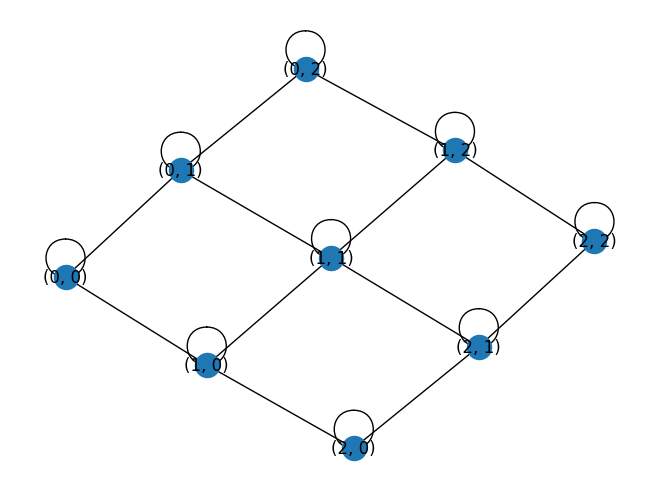

In [ ]:
# inserting a self-edge to every node in the graph
self_edges = [(node, node) for node in G.nodes()]
G.add_edges_from(self_edges)

nx.draw(G, with_labels=True)
plt.show()

In [ ]:
# attaching real-valued wright to every edge, drawn uniformly from the range [0.2, 1]
for u, v in G.edges():
  G[u][v]['weight'] = random.uniform(0.2, 1)

for u, v, w in G.edges.data('weight'):
  print(f"({u}, {v}): {w}")

((0, 0), (1, 0)): 0.6585468608619534
((0, 0), (0, 1)): 0.5656243366492013
((0, 0), (0, 0)): 0.28175592742003586
((0, 1), (1, 1)): 0.49636798920813974
((0, 1), (0, 2)): 0.8107308781377747
((0, 1), (0, 1)): 0.6225881046016406
((0, 2), (1, 2)): 0.2346766135918406
((0, 2), (0, 2)): 0.9818652818795546
((1, 0), (2, 0)): 0.9256739989189549
((1, 0), (1, 1)): 0.2792139295612381
((1, 0), (1, 0)): 0.6829156167030157
((1, 1), (2, 1)): 0.5965651803671204
((1, 1), (1, 2)): 0.934318015009141
((1, 1), (1, 1)): 0.3391439414265416
((1, 2), (2, 2)): 0.6725379759356496
((1, 2), (1, 2)): 0.9457173085542439
((2, 0), (2, 1)): 0.9560944051620168
((2, 0), (2, 0)): 0.3026435936118368
((2, 1), (2, 2)): 0.8911946978435576
((2, 1), (2, 1)): 0.9975818452667033
((2, 2), (2, 2)): 0.840350835281066


### Erdős–Rényi graphs

Erdős–Rényi graphs are a class of graphs that are generated randomly using a probabilistic model. We start with fixed number of nodes n and then add edges between pairs of nodes with a certain probability p. The edges are added randomly and independently of each other, meaning that any pair of nodes has an equal probability of being connected by an edge. 

In the paper, graph have edge probability min(log_2(|V|)/|V|, 0.5)

In [ ]:
n = 10 # number of nodes
p = min(math.log(n, 2)/n, 0.5) # edge probability
print(p)

# create 2d grid graph
G = nx.erdos_renyi_graph(n, p)

# draw graph
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
G.adj

In [ ]:
G.nodes

In [ ]:
# inserting a self-edge to every node in the graph
self_edges = [(node, node) for node in G.nodes()]
G.add_edges_from(self_edges)

nx.draw(G, with_labels=True)
plt.show()

In [ ]:
# attaching real-valued wright to every edge, drawn uniformly from the range [0.2, 1]
for u, v in G.edges():
  G[u][v]['weight'] = random.uniform(0.2, 1)

for u, v, w in G.edges.data('weight'):
  print(f"({u}, {v}): {w}")

# Generating dataset

For each category, we generate 100 training and 5 validation graphs of only 20 nodes. For testing, 5 additional of 20, 50 and 100 nodes are generated per category.  

In [ ]:
def generate_self_edges(G):
  self_edges = [(node, node) for node in G.nodes()]
  G.add_edges_from(self_edges)
  return G

In [ ]:
def generate_edge_weights(G):
  for u, v in G.edges():
    G[u][v]['weight'] = random.uniform(0.2, 1)
  return G

In [ ]:
def generate_all_graph_types(N_graphs, N_nodes):
  exceptions = {50: (7, 7)}
  add = False

  graphs = []
  for g in range(N_graphs):
    # ladder graph
    n = int(N_nodes / 2)   # number of rungs = number of nodes / 2
    G = nx.ladder_graph(n)
    G = generate_self_edges(G)
    G = generate_edge_weights(G)
    graphs.append(G)

    # 2D grid graph
    n = int(math.ceil(math.sqrt(N_nodes))) # number of rows
    m = int(math.ceil(N_nodes / n)) # number of columns
    if m*n != N_nodes:
      n, m = exceptions[N_nodes]
      add = True
    G = nx.grid_2d_graph(n, m)
    if add:
      G.add_node((6, 7))
      G.add_edge((6, 6), (6, 7))
      add = False
    G = generate_self_edges(G)
    G = generate_edge_weights(G)
    graphs.append(G)

    # Erdos Renyi graph
    p = min(math.log(N_nodes, 2)/N_nodes, 0.5) # edge probability
    G = nx.erdos_renyi_graph(N_nodes, p)
    G = generate_self_edges(G)
    G = generate_edge_weights(G)
    graphs.append(G)

  return graphs

In [ ]:
N_train = 100
N_val = 5
N_nodes_train = 20
N_nodes_val = 20
N_test = 5
N_nodes_test_list = [20, 50, 100]

train_graphs = generate_all_graph_types(N_train, N_nodes_train)
val_graphs = generate_all_graph_types(N_val, N_nodes_val)
test_graphs = []
for N_nodes_test in N_nodes_test_list:
  test_graphs.extend(generate_all_graph_types(N_test, N_nodes_test))

print('Number of training graphs =', len(train_graphs))
print('Number of validation graphs =', len(val_graphs))
print('Number of test graphs =', len(test_graphs))


Number of training graphs = 300
Number of validation graphs = 15
Number of test graphs = 45


In [ ]:
# saving graphs in pickle file so I can just load them next time
filename = path_to_file + 'data/train_graphs.pkl'
with open(filename, 'wb') as f:
    pickle.dump(train_graphs, f)

filename = path_to_file + 'data/val_graphs.pkl'
with open(filename, 'wb') as f:
    pickle.dump(val_graphs, f)

filename = path_to_file + 'data/test_graphs.pkl'
with open(filename, 'wb') as f:
    pickle.dump(test_graphs, f)

# Load generated dataset

In [10]:
# loading graphs from pickle files
filename = path_to_file + 'data/train_graphs.pkl'
with open(filename, 'rb') as f:
    train_graphs = pickle.load(f)

filename = path_to_file + 'data/val_graphs.pkl'
with open(filename, 'rb') as f:
    val_graphs = pickle.load(f)

filename = path_to_file + 'data/test_graphs.pkl'
with open(filename, 'rb') as f:
    test_graphs = pickle.load(f)


# Algorithm steps definition

Input to a graph is a sequence of T graph-structure inputs. For each element of the sequence, a fixed graph G and vary meta-data associated with the nodes and edges of the graph in the input are used. 

In [11]:
def bfs_step(graph, init=False, source_node=None, label_name='bfs_label'):
  G_copy = copy.deepcopy(graph)
  if init:
    for node in graph.nodes():
      G_copy.nodes[node][label_name] = 0.
    # choosing the source node
    if source_node is None:
      nodes = list(graph.nodes())
      index = random.randint(0, len(nodes) - 1)
      source_node = nodes[index]
    else:
      source_node = source_node
    G_copy.graph['source_node'] = source_node
    # setting the source node
    G_copy.nodes[source_node][label_name] = 1.
    return G_copy
  
  for node in graph.nodes():
    if graph.nodes[node][label_name] == 1:
      for neighbor in graph.neighbors(node):
        if graph.nodes[neighbor][label_name] == 0:
          G_copy.nodes[neighbor][label_name] = 1.
  return G_copy
    

In [12]:
def bellman_ford_step(graph, init=False, source_node=None, label_name='bf_label', predecessor_label='pred'): # TODO mozda je zapravo svatko sam sebi predecessor na pocetku cisto po formuli
  # To provide a numerically stable value for +inf, such entries are set to 
  # the lenght of the longest shortest path in the graph + 1

  G_copy = copy.deepcopy(graph)
  nodes = list(graph.nodes())
  if init:
    # choosing the source node
    if source_node is None:
      index = random.randint(0, len(nodes) - 1)
      source_node = nodes[index]
    else:
      source_node = source_node
    # calculating the longest shortest path
    path_lengths = nx.single_source_dijkstra_path_length(G_copy, source_node)
    longest_shortest_path = max(path_lengths.values())
    G_copy.graph['longest_shortest_path'] = longest_shortest_path + 1

    for i, node in enumerate(graph.nodes()):
      G_copy.nodes[node][label_name] = G_copy.graph['longest_shortest_path']
      # because of categorical cross entropy predecessor needs to be set on some node, so itself
      G_copy.nodes[node][predecessor_label] = i
    
    G_copy.nodes[source_node][label_name] = 0.
    G_copy.graph['source_node'] = source_node # predecessor label of the source_node already set on itself
    return G_copy
  
  for node in graph.nodes():
    current = graph.nodes[node][label_name] 
    pred = -1.
    for neighbor in graph.neighbors(node):
      edge_data = graph.get_edge_data(node, neighbor)
      weight = edge_data['weight']
      if graph.nodes[neighbor][label_name] + weight < current:
        current = min(current, graph.nodes[neighbor][label_name] + weight)
        pred = neighbor
    if current < graph.nodes[node][label_name]:
      G_copy.nodes[node][label_name] = current
      # setting predecessor
      i = nodes.index(pred)
      G_copy.nodes[node][predecessor_label] = i
  return G_copy

## Trying out 1 step of each algorithm

### BFS

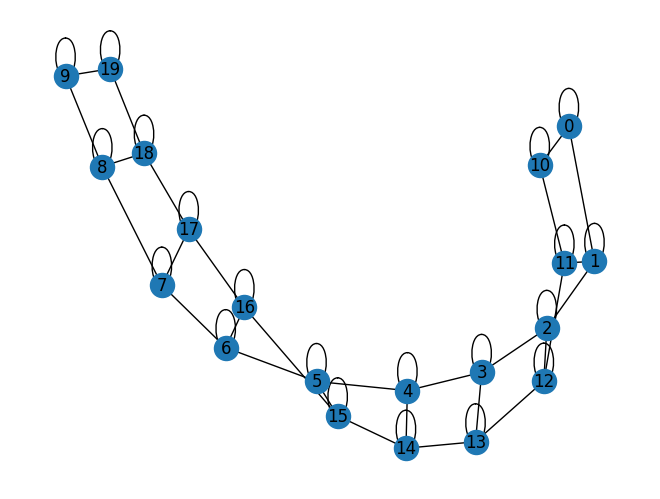

In [ ]:
G = train_graphs[0]
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
print(nx.get_node_attributes(G, 'bfs_label'))

{}


In [ ]:
new_g = bfs_step(G, init=True)
print(nx.get_node_attributes(new_g, 'bfs_label'))

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 1.0}


In [ ]:
new_g1 = bfs_step(new_g)
print(nx.get_node_attributes(new_g1, 'bfs_label'))

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 1.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 1.0, 19: 1.0}


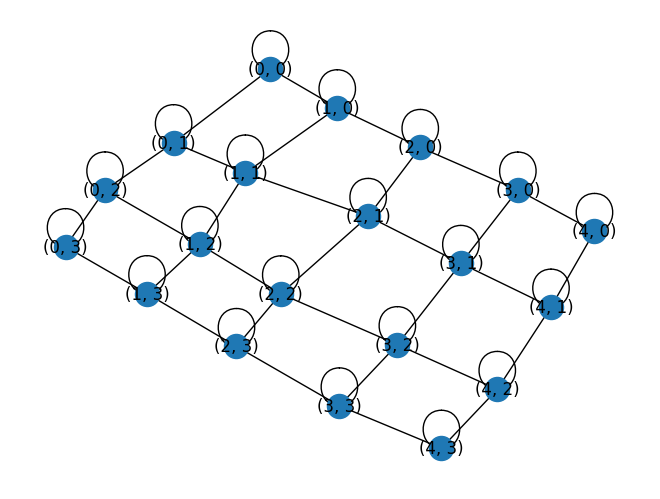

In [ ]:
G = train_graphs[1]
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
print(nx.get_node_attributes(G, 'bfs_label'))

{}


In [ ]:
new_g = bfs_step(G, init=True)
print(nx.get_node_attributes(new_g, 'bfs_label'))

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 1.0, (1, 2): 0.0, (1, 3): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 0.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 0.0}


In [ ]:
new_g1 = bfs_step(new_g)
print(nx.get_node_attributes(new_g1, 'bfs_label'))

{(0, 0): 0.0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 1.0, (1, 1): 1.0, (1, 2): 1.0, (1, 3): 0.0, (2, 0): 0.0, (2, 1): 1.0, (2, 2): 0.0, (2, 3): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 0.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 0.0}


### Bellman-Ford

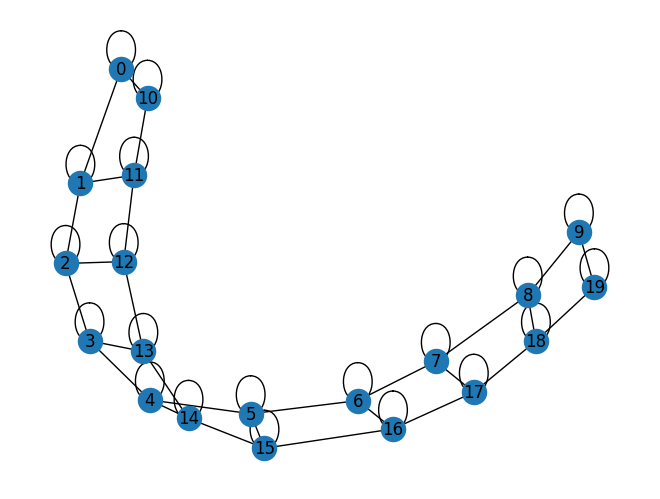

In [ ]:
G = train_graphs[0]
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
for u, v, w in G.edges.data('weight'):
  print(f"({u}, {v}): {w}")

(0, 1): 0.20809371148685918
(0, 10): 0.9738793707828375
(0, 0): 0.6952959038405415
(1, 2): 0.8131801401908936
(1, 11): 0.9637593288216983
(1, 1): 0.6960937883318042
(2, 3): 0.9189763778066016
(2, 12): 0.36544687974919826
(2, 2): 0.5120272711865306
(3, 4): 0.8640216428515732
(3, 13): 0.4694634861405333
(3, 3): 0.4395890451478641
(4, 5): 0.5989959864920503
(4, 14): 0.7801015631519126
(4, 4): 0.8355724622225342
(5, 6): 0.5040996631316612
(5, 15): 0.8266730341076765
(5, 5): 0.8057662126283744
(6, 7): 0.6882481786118113
(6, 16): 0.9823842668853373
(6, 6): 0.2603129649513533
(7, 8): 0.3039961239396882
(7, 17): 0.5231147369156628
(7, 7): 0.44328102465998065
(8, 9): 0.44937771683097694
(8, 18): 0.9928508599167929
(8, 8): 0.923233113107099
(9, 19): 0.6089559663189088
(9, 9): 0.5944293928562188
(10, 11): 0.5654362133878932
(10, 10): 0.6598579515262443
(11, 12): 0.5532668542017269
(11, 11): 0.5995900766213609
(12, 13): 0.6006973013418624
(12, 12): 0.404032172725982
(13, 14): 0.9666149185836013
(1

In [ ]:
new_g = bellman_ford_step(G, init=True)
print(nx.get_node_attributes(new_g, 'bf_label'))
print(nx.get_node_attributes(G, 'bf_label'))
print(nx.get_node_attributes(new_g, 'pred'))

{0: 6.087856065659066, 1: 6.087856065659066, 2: 6.087856065659066, 3: 6.087856065659066, 4: 6.087856065659066, 5: 6.087856065659066, 6: 6.087856065659066, 7: 6.087856065659066, 8: 6.087856065659066, 9: 6.087856065659066, 10: 6.087856065659066, 11: 6.087856065659066, 12: 0.0, 13: 6.087856065659066, 14: 6.087856065659066, 15: 6.087856065659066, 16: 6.087856065659066, 17: 6.087856065659066, 18: 6.087856065659066, 19: 6.087856065659066}
{}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19}


In [ ]:
new_g1 = bellman_ford_step(new_g)
print(nx.get_node_attributes(new_g1, 'bf_label'))
print(nx.get_node_attributes(new_g1, 'pred'))

{0: 6.087856065659066, 1: 6.087856065659066, 2: 0.36544687974919826, 3: 6.087856065659066, 4: 6.087856065659066, 5: 6.087856065659066, 6: 6.087856065659066, 7: 6.087856065659066, 8: 6.087856065659066, 9: 6.087856065659066, 10: 6.087856065659066, 11: 0.5532668542017269, 12: 0.0, 13: 0.6006973013418624, 14: 6.087856065659066, 15: 6.087856065659066, 16: 6.087856065659066, 17: 6.087856065659066, 18: 6.087856065659066, 19: 6.087856065659066}
{0: 0, 1: 1, 2: 12, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 12, 12: 12, 13: 12, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19}


In [ ]:
G = train_graphs[1]
new_g = bellman_ford_step(G, init=True)
print('initial step')
print(nx.get_node_attributes(new_g, 'bf_label'))
print(nx.get_node_attributes(new_g, 'pred'))

new_g1 = bellman_ford_step(new_g)
print('next step')
print(nx.get_node_attributes(new_g1, 'bf_label'))
print(nx.get_node_attributes(new_g1, 'pred'))

initial step
{(0, 0): 3.4367399997526134, (0, 1): 3.4367399997526134, (0, 2): 3.4367399997526134, (0, 3): 3.4367399997526134, (1, 0): 3.4367399997526134, (1, 1): 3.4367399997526134, (1, 2): 3.4367399997526134, (1, 3): 3.4367399997526134, (2, 0): 3.4367399997526134, (2, 1): 3.4367399997526134, (2, 2): 3.4367399997526134, (2, 3): 3.4367399997526134, (3, 0): 3.4367399997526134, (3, 1): 3.4367399997526134, (3, 2): 3.4367399997526134, (3, 3): 0.0, (4, 0): 3.4367399997526134, (4, 1): 3.4367399997526134, (4, 2): 3.4367399997526134, (4, 3): 3.4367399997526134}
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 13, (3, 2): 14, (3, 3): 15, (4, 0): 16, (4, 1): 17, (4, 2): 18, (4, 3): 19}
next step
{(0, 0): 3.4367399997526134, (0, 1): 3.4367399997526134, (0, 2): 3.4367399997526134, (0, 3): 3.4367399997526134, (1, 0): 3.4367399997526134, (1, 1): 3.4367399997526134, (1, 2): 3.4367399997526134, (1,

# Helper functions

In [13]:
def prepare_initial_graph(G, source_node=None):
  G = bfs_step(G, init=True, source_node=source_node)
  # same source node for both algorithms
  source_node = G.graph['source_node']
  G = bellman_ford_step(G, init=True, source_node=source_node)
  return G

In [14]:
def node_match_bfs(G1_node, G2_node):
  # G1_node are all features for one node in G1 in a dictionary form
  if G1_node['bfs_label'] == G2_node['bfs_label']:
    return True
  else:
    return False

def node_match_bf(G1_node, G2_node):
  # G1_node are all features for one node in G1 in a dictionary form
  if G1_node['pred'] == G2_node['pred'] and math.isclose(G1_node['bf_label'], G2_node['bf_label'], rel_tol=1e-7):
    return True
  else:
    return False

def edge_match(G1_edge, G2_edge):
  # G1_edge are all features for one edge in G1 in a dictionary form
  if math.isclose(G1_edge['weight'], G2_edge['weight'], rel_tol=1e-7):
    return True
  else:
    return False


In [15]:
def prepare_pyg_data(G, hidden_dim=-1, h1=None, h2=None): 
  d = tg.utils.convert.from_networkx(G)
  d.edge_attr = d.weight
  if h1 is None or h2 is None:
    d.h_bfs = torch.zeros((d.num_nodes, hidden_dim))
    d.h_bf = torch.zeros((d.num_nodes, hidden_dim))
  else:
    d.h_bfs = h1.detach()
    d.h_bf = h2.detach()
  next_G = bfs_step(G)
  next_G = bellman_ford_step(next_G)
  d1 = tg.utils.convert.from_networkx(next_G) 
  # algoritham needs to continue further -> terminated set to 1 (when algorithm finishes, set to 0)
  bfs_terminated = 0. if nx.is_isomorphic(G, next_G, node_match=node_match_bfs, edge_match=edge_match) else 1.
  bf_terminated = 0. if nx.is_isomorphic(G, next_G, node_match=node_match_bf, edge_match=edge_match) else 1.
  # output labels are inputs of the next step
  d.y = [d1.bfs_label.reshape(-1, 1).clone(), d1.bf_label.reshape(-1, 1).clone(), d1.pred.clone().long(), torch.tensor([bfs_terminated]), torch.tensor([bf_terminated])] # TODO probably going to need to change for predecessor 
  return d, next_G # return new_graph as well so it can be used in next time step of the sequence

In [48]:
def prepare_pyg_data_for_bfs(G, hidden_dim=-1, h1=None): 
  d = tg.utils.convert.from_networkx(G)
  d.edge_attr = d.weight
  if h1 is None:
    d.h_bfs = torch.zeros((d.num_nodes, hidden_dim))
  else:
    d.h_bfs = h1.detach()
  next_G = bfs_step(G)
#  next_G = bellman_ford_step(next_G)
  d1 = tg.utils.convert.from_networkx(next_G)
  # algoritham needs to continue further -> terminated set to 1 (when algorithm finishes, set to 0)
  bfs_terminated = 0. if nx.is_isomorphic(G, next_G, node_match=node_match_bfs, edge_match=edge_match) else 1.
#  bf_terminated = 0. if nx.is_isomorphic(G, next_G, node_match=node_match_bf, edge_match=edge_match) else 1.
  # output labels are inputs of the next step
  d.y = [d1.bfs_label.reshape(-1, 1).clone(), torch.tensor([bfs_terminated])] # TODO probably going to need to change for predecessor 
  return d, next_G # return new_graph as well so it can be used in next time step of the sequence

In [49]:
def prepare_pyg_data_for_bf(G, hidden_dim=-1, h1=None): 
  d = tg.utils.convert.from_networkx(G)
  d.edge_attr = d.weight
  if h1 is None:
    d.h_bf = torch.zeros((d.num_nodes, hidden_dim))
  else:
    d.h_bf = h1.detach()
  next_G = bellman_ford_step(G)
#  next_G = bfs_step(next_G)
  d1 = tg.utils.convert.from_networkx(next_G)
  # algoritham needs to continue further -> terminated set to 1 (when algorithm finishes, set to 0)
#  bfs_terminated = 0. if nx.is_isomorphic(G, next_G, node_match=node_match_bfs, edge_match=edge_match) else 1.
  bf_terminated = 0. if nx.is_isomorphic(G, next_G, node_match=node_match_bf, edge_match=edge_match) else 1.
  # output labels are inputs of the next step
  d.y = [d1.bf_label.reshape(-1, 1).clone(), torch.tensor([bf_terminated]), d1.pred.clone().long()] # TODO probably going to need to change for predecessor 
  return d, next_G # return new_graph as well so it can be used in next time step of the sequence

In [18]:
def prepare_output(out, pred=False):
  # We have to split BFoutput because it is representing distance and predecessor, and
  # we need to prepare outputs - each has to be seperate so we can use appropriate loss 
  (bfs_out, bfs_term, bfs_h) = out[0]
  (bf_dist, bf_term, bf_h) = out[1]
  if pred:
    bf_pred = out[2]
  else:
    bf_pred = None
  return bfs_out, bf_dist, bf_pred, bfs_term, bf_term, bfs_h, bf_h # TODO check termination output

In [19]:
def prepare_output_one_alg(out, pred=False):
  # We have to split BFoutput because it is representing distance and predecessor, and
  # we need to prepare outputs - each has to be seperate so we can use appropriate loss 
  (alg_out, term, h) = out[0]
  if pred:
    pred = out[1]
    return alg_out, term, pred, h
  return alg_out, term, h 

### Try out

In [ ]:
G = train_graphs[0]
G = prepare_initial_graph(G)
d = tg.utils.convert.from_networkx(G)
d.edge_attr = d.weight
hidden_dim = 32
d.h_bfs = torch.zeros((d.num_nodes, hidden_dim))
d.h_bf = torch.zeros((d.num_nodes, hidden_dim))
next_G = bfs_step(G)
next_G = bellman_ford_step(next_G)
d1 = tg.utils.convert.from_networkx(next_G)
bfs_terminated = 1. if nx.is_isomorphic(G, next_G, node_match=node_match_bfs, edge_match=edge_match) else 0.
bf_terminated = 1. if nx.is_isomorphic(G, next_G, node_match=node_match_bf, edge_match=edge_match) else 0.
d.y = [d1.bfs_label.reshape(-1, 1), d1.bf_label.reshape(-1, 1), d1.pred.reshape(-1, 1), torch.tensor([bfs_terminated]), torch.tensor([bf_terminated])] # TODO probably going to need to change for predecessor  
d

Data(edge_index=[2, 76], bfs_label=[20], bf_label=[20], pred=[20], weight=[76], source_node=6, longest_shortest_path=5.155981063842773, num_nodes=20, edge_attr=[76], h_bfs=[20, 32], h_bf=[20, 32], y=[5])

In [ ]:
d.bf_label

tensor([5.1560, 5.1560, 5.1560, 5.1560, 5.1560, 5.1560, 0.0000, 5.1560, 5.1560,
        5.1560, 5.1560, 5.1560, 5.1560, 5.1560, 5.1560, 5.1560, 5.1560, 5.1560,
        5.1560, 5.1560])

In [ ]:
d.y

[tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.]]),
 tensor([[5.1560],
         [5.1560],
         [5.1560],
         [5.1560],
         [5.1560],
         [0.5041],
         [0.0000],
         [0.6882],
         [5.1560],
         [5.1560],
         [5.1560],
         [5.1560],
         [5.1560],
         [5.1560],
         [5.1560],
         [5.1560],
         [0.9824],
         [5.1560],
         [5.1560],
         [5.1560]]),
 tensor([[ 0],
         [ 1],
         [ 2],
         [ 3],
         [ 4],
         [ 6],
         [ 6],
         [ 6],
         [ 8],
         [ 9],
         [10],
         [11],
         [12],
         [13],
         [14],
         [15],
         [ 6],
         [17],
         [18],
         [19]]),
 tensor([0.]),

In [ ]:
d.x = torch.stack([d['bfs_label'], d['bf_label']], dim=1)
d.x

tensor([[0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [1.0000, 0.0000],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560],
        [0.0000, 5.1560]])

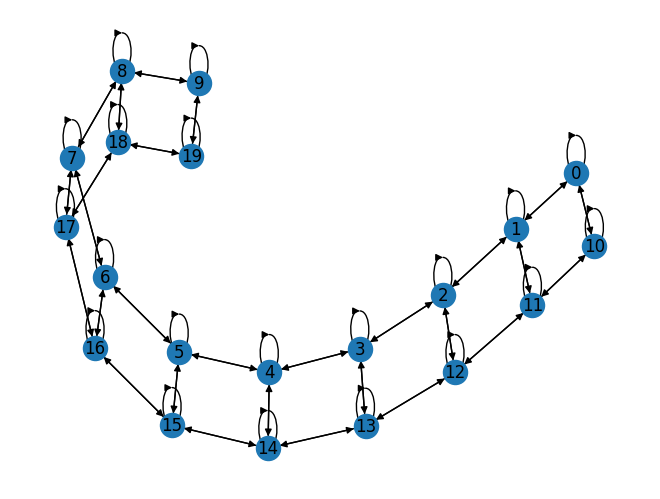

In [ ]:
g = tg.utils.convert.to_networkx(d)
nx.draw(g, with_labels=True)
plt.show()

# Networks

In [21]:
class BFSEncoder(torch.nn.Module):
  def __init__(self, in_dim, out_dim):
    super(BFSEncoder, self).__init__()
    self.linear = torch.nn.Linear(in_dim, out_dim)
    self.relu = torch.nn.ReLU()
        
  def forward(self, x):
    bfs_label = x.bfs_label.unsqueeze(1)
    input = torch.cat([bfs_label, x.h_bfs], dim=1)
    return self.relu(self.linear(input))


class BFSDecoder(torch.nn.Module):
  def __init__(self, in_dim, out_dim):
    super(BFSDecoder, self).__init__()
    self.linear = torch.nn.Linear(in_dim, out_dim)
        
  def forward(self, z, h):
    input = torch.cat([z, h], dim=1)
    return self.linear(input) 
 
  
class BFSTermination(torch.nn.Module):
  def __init__(self, in_dim, out_dim):
    super(BFSTermination, self).__init__()
    self.linear = torch.nn.Linear(in_dim, out_dim)
        
  def forward(self, x):
    mean = torch.mean(x, dim=0)
    input = torch.cat((x, mean.unsqueeze(0)), dim=0)
    out = self.linear(input)
    return out[-1]

In [22]:
class BFEncoder(torch.nn.Module):
  def __init__(self, in_dim, out_dim):
    super(BFEncoder, self).__init__()
    self.linear = torch.nn.Linear(in_dim, out_dim)
    self.relu = torch.nn.ReLU()
        
  def forward(self, x):
    bf_label = x.bf_label.unsqueeze(1)
    input = torch.cat([bf_label, x.h_bf], dim=1)
    return self.relu(self.linear(input))


class BFDecoder(torch.nn.Module):
  def __init__(self, in_dim, out_dim):
    super(BFDecoder, self).__init__()
    self.linear = torch.nn.Linear(in_dim, out_dim)
        
  def forward(self, z, h):
    input = torch.cat([z, h], dim=1)
    return self.linear(input) # TODO you will need to fix for predecessor

class BFPredecessorDecoder(tg.nn.MessagePassing):
  def __init__(self, in_channels, out_channels, edge_dim):
    super(BFPredecessorDecoder, self).__init__(aggr='add')
    self.linear = torch.nn.Linear(2 * in_channels + edge_dim, out_channels)
  
  def forward(self, x, edge_index, edge_attr):
    return self.propagate(edge_index, x=x, edge_attr=edge_attr)
  
  def message(self, x_i, x_j, edge_attr):
    edge_attr = edge_attr.view(-1, self.edge_dim) # when having only one edge feature, shape will be (num_edges), so it has to be transformed
    input = torch.cat([x_i, x_j, edge_attr], dim=-1)
    return self.linear(input)
  
  def update(self, aggr_out):
    
    return aggr_out


class BFTermination(torch.nn.Module):
  def __init__(self, in_dim, out_dim):
    super(BFTermination, self).__init__()
    self.linear = torch.nn.Linear(in_dim, out_dim)
        
  def forward(self, x):
    mean = torch.mean(x, dim=0)
    input = torch.cat((x, mean.unsqueeze(0)), dim=0)
    out = self.linear(input)
    return out[-1]

In [23]:
class PredecessorMessageFunction(torch.nn.Module):
  def __init__(self, in_channels, out_channels, edge_dim):
    super(PredecessorMessageFunction, self).__init__()
    self.linear = torch.nn.Linear(in_channels * 2 + edge_dim, out_channels)
    self.edge_dim = edge_dim

  def forward(self, x, edge_index, edge_attr):
    src = x[edge_index[0]]  # shape [num_edges, in_channels]
    dst = x[edge_index[1]]  # shape [num_edges, in_channels]
        
    # Concatenate node features, edge features, and apply linear layer
    edge_attr = edge_attr.view(-1, self.edge_dim)
    input = torch.cat([src, dst, edge_attr], dim=-1)
    out = self.linear(input)  # shape [num_edges, out_channels]
        
    # Zero-pad output tensor with shape [num_nodes, out_channels]
    num_nodes = x.size(0)
    out_padded = torch.zeros(num_nodes, num_nodes)
    for i in range(edge_index.shape[1]):
      src = edge_index[0][i]
      dst = edge_index[1][i]
      out_padded[src, dst] = out[i]
    return out_padded


In [24]:
class GATProcessor(torch.nn.Module):
  def __init__(self, in_channels, out_channels, edge_dim, heads=1, dropout=0.0): #add_self_loops set to True by default, but what happens if there are already self loops?
    super(GATProcessor, self).__init__()
    self.conv1 = tg.nn.GATConv(in_channels, out_channels, heads=heads, edge_dim=edge_dim, dropout=dropout)
        
  def forward(self, x, edge_index, edge_attr):
    x = self.conv1(x, edge_index, edge_attr)
    return x

In [25]:
# my implementation of GATProcessor 
class GATProcessor2(tg.nn.MessagePassing):
  def __init__(self, in_channels, out_channels, edge_dim):
    super(GATProcessor2, self).__init__(aggr='max') 
    self.edge_dim = edge_dim
    self.fc = torch.nn.Linear(in_channels, out_channels)
    self.attn = torch.nn.Linear(2 * out_channels + edge_dim, 1)

  def forward(self, x, edge_index, edge_attr):
    x = self.fc(x)
    return self.propagate(edge_index, x=x, edge_attr=edge_attr)

  def message(self, x_i, x_j, edge_attr):
    edge_attr = edge_attr.view(-1, self.edge_dim)
    alpha_input = torch.cat([x_i, x_j, edge_attr], dim=-1)
    alpha = self.attn(alpha_input)
    alpha = torch.nn.functional.leaky_relu(alpha, negative_slope=0.2)
    return torch.nn.functional.softmax(alpha, dim=0) * x_j

  def update(self, aggr_out):
    return torch.nn.functional.leaky_relu(aggr_out)

In [26]:
class MPNNProcessor(tg.nn.MessagePassing):
  def __init__(self, in_channels, out_channels, edge_dim, aggr): #in_channels is dim of node features
    super(MPNNProcessor, self).__init__(aggr=aggr) 
    self.edge_dim = edge_dim
    M_in_channels = in_channels * 2 + edge_dim
    self.M = torch.nn.Linear(M_in_channels, out_channels)
    U_in_channels = in_channels + out_channels
    self.U = torch.nn.Linear(U_in_channels, out_channels)
    self.relu = torch.nn.ReLU()

  def reset_parameters(self):
    self.M.reset_parameters()
    self.U.reset_parameters()

  def forward(self, x, edge_index, edge_attr):
    return self.propagate(edge_index, x=x, edge_attr=edge_attr)

  def message(self, x_i, x_j, edge_attr): # x_i and x_j are node feature matrices of shape (num_edges, input_node_features_dim)
    edge_attr = edge_attr.view(-1, self.edge_dim) # when having only one edge feature, shape will be (num_edges), so it has to be transformed
    input = torch.cat([x_i, x_j, edge_attr], dim=-1)
    return self.relu(self.M(input))  # returns matrix of shape (num_edges, out_channels) which is aggregated with aggr function in aggr_out

  def update(self, aggr_out, x): # aggr_out has shape (num_nodes, out_channels)
    input = torch.cat([x, aggr_out], dim=-1)
    return self.relu(self.U(input))

In [27]:
class NeuralExecutor(torch.nn.Module):
  def __init__(self, Processor, Encoders, Decoders, TerminationNetworks, in_dims, out_dims, hidden_dim, pred=None, **kwargs): # TODO maybe rewrite so you can give encoders and termination and decoder as param, seconda is optional, and have param self.parallel if you have to do 2 at once and concat
    super(NeuralExecutor, self).__init__()
    if not isinstance(Encoders, list) or not isinstance(Decoders, list) or not isinstance(TerminationNetworks, list):
      raise TypeError("Arguments Encoders, Decoders and TerminationNetworks must be a list")
    if len(Encoders) != len(Decoders) or len(Decoders) != len(TerminationNetworks):
      raise AssertionError('You should have equal number of encoders, decoders and termination networks, one for each algorithm')
    if len(Encoders) > 2:
      raise NotImplementedError('Currently only implemented for one or two algorithms running simultaneously.')
    
    self.n = len(Encoders)
    self.processor = Processor(hidden_dim, hidden_dim, **kwargs)
    self.encoders = []
    self.decoders = []
    self.terminators = []
    for i in range(self.n):
      self.encoders.append(Encoders[i](in_dims[i] + hidden_dim, hidden_dim)) # input to the encoder is x(t) and h(t-1), output is z(t)
      self.decoders.append(Decoders[i](2 * hidden_dim, out_dims[i])) # input to the decoder is z(t) and h(t), output is y(t)
      self.terminators.append(TerminationNetworks[i](hidden_dim, 1)) # output dimension for termination network always 1
    if pred is not None:
      self.pred = pred
    else:
      self.pred = None

  def forward(self, data): 
    out = []
    for i in range(self.n):
      z = self.encoders[i](data)
      h = self.processor(z,data.edge_index, data.edge_attr)
      y = self.decoders[i](z, h)
      tau = self.terminators[i](h)
      out.append((y, tau, h))
    if self.pred is not None:
      out.append(self.pred(h, data.edge_index, data.edge_attr))
    return out

### Try out

In [28]:
G = train_graphs[0]
current_graph = prepare_initial_graph(G)
d, next_graph = prepare_pyg_data(current_graph, hidden_dim=32)

In [29]:
network = NeuralExecutor(MPNNProcessor, [BFSEncoder, BFEncoder], [BFSDecoder, BFDecoder], [BFSTermination, BFTermination], in_dims=[1,1], out_dims=[1,2], hidden_dim=32, edge_dim=1, aggr='max')

In [30]:
out = network(d)
bfs_out, bfs_term, bfs_h = out[0]
bf_out, bf_term, bf_h = out[1]
print(bfs_out.shape)
print(bfs_out)
print(bf_out.shape)
print(bf_out)
print(bfs_term.shape)
print(bfs_term)
print(bf_term.shape)
print(bf_term)
print(bfs_h.shape)
print(bfs_h)
print(bf_h.shape)
print(bf_h)

torch.Size([20, 1])
tensor([[0.0353],
        [0.0358],
        [0.0353],
        [0.0349],
        [0.0348],
        [0.0355],
        [0.0353],
        [0.0380],
        [0.0350],
        [0.0378],
        [0.0217],
        [0.0333],
        [0.0384],
        [0.0343],
        [0.0348],
        [0.0347],
        [0.0347],
        [0.0349],
        [0.0344],
        [0.0358]], grad_fn=<AddmmBackward0>)
torch.Size([20, 2])
tensor([[-0.0532, -0.0109],
        [-0.0500, -0.0138],
        [-0.0502, -0.0137],
        [-0.0505, -0.0136],
        [-0.0507, -0.0135],
        [-0.0501, -0.0138],
        [-0.0503, -0.0136],
        [-0.0486, -0.0146],
        [-0.0505, -0.0135],
        [-0.0486, -0.0147],
        [-0.0417,  0.0424],
        [-0.0543, -0.0106],
        [-0.0482, -0.0149],
        [-0.0509, -0.0133],
        [-0.0506, -0.0135],
        [-0.0507, -0.0134],
        [-0.0506, -0.0134],
        [-0.0505, -0.0135],
        [-0.0509, -0.0133],
        [-0.0500, -0.0139]], grad_fn=<Add

In [31]:
network = NeuralExecutor(MPNNProcessor, [BFSEncoder, BFEncoder], [BFSDecoder, BFDecoder], [BFSTermination, BFTermination], in_dims=[1,1], out_dims=[1,2], hidden_dim=32, edge_dim=1, aggr='max')

In [32]:
out = network(d)
bfs_out, bfs_term, bfs_h = out[0]
bf_out, bf_term, bf_h = out[1]
print(bfs_out.shape)
print(bfs_out)
print(bf_out.shape)
print(bf_out)
print(bfs_term.shape)
print(bfs_term)
print(bf_term.shape)
print(bf_term)
print(bfs_h.shape)
#print(bfs_h)
print(bf_h.shape)
#print(bf_h)

torch.Size([20, 1])
tensor([[-0.0243],
        [-0.0255],
        [-0.0257],
        [-0.0256],
        [-0.0253],
        [-0.0254],
        [-0.0256],
        [-0.0255],
        [-0.0258],
        [-0.0254],
        [-0.0220],
        [-0.0241],
        [-0.0255],
        [-0.0256],
        [-0.0258],
        [-0.0258],
        [-0.0258],
        [-0.0257],
        [-0.0257],
        [-0.0252]], grad_fn=<AddmmBackward0>)
torch.Size([20, 2])
tensor([[ 0.0747,  0.1462],
        [ 0.0780,  0.1493],
        [ 0.0790,  0.1484],
        [ 0.0794,  0.1479],
        [ 0.0807,  0.1472],
        [ 0.0801,  0.1477],
        [ 0.0782,  0.1489],
        [ 0.0794,  0.1490],
        [ 0.0785,  0.1486],
        [ 0.0805,  0.1482],
        [-0.0663,  0.0241],
        [ 0.0771,  0.1432],
        [ 0.0801,  0.1487],
        [ 0.0795,  0.1476],
        [ 0.0788,  0.1483],
        [ 0.0788,  0.1482],
        [ 0.0789,  0.1482],
        [ 0.0787,  0.1484],
        [ 0.0791,  0.1479],
        [ 0.0810,  0.

In [33]:
# only BFS
network = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=[1], out_dims=[1], hidden_dim=32, edge_dim=1, aggr='max')
(bfs_out, bfs_term, bfs_h) = network(d)[0]
print(bfs_out.shape)
print(bfs_out)
print(bfs_term.shape)
print(bfs_term)
print(bfs_h.shape)
#print(bfs_h)

torch.Size([20, 1])
tensor([[0.0138],
        [0.0138],
        [0.0120],
        [0.0112],
        [0.0098],
        [0.0104],
        [0.0133],
        [0.0120],
        [0.0129],
        [0.0104],
        [0.0023],
        [0.0113],
        [0.0112],
        [0.0111],
        [0.0124],
        [0.0122],
        [0.0122],
        [0.0125],
        [0.0118],
        [0.0095]], grad_fn=<AddmmBackward0>)
torch.Size([1])
tensor([0.0882], grad_fn=<SelectBackward0>)
torch.Size([20, 32])


# Training

In [20]:
def train(model, train_data, val_data, criteria, hidden_dim, prepare_pyg, prepare_output, val='bfs', num_epochs=100, learning_rate=0.0005, train_source_nodes=None, val_source_nodes=None, pred=False):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  best_val_acc = 0
  patience = 10
  early_stopping_counter = 0
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []
    
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0 
    train_total = 0
    train_count = 0
        
    for i, data in enumerate(train_data): # data is plain graph and the sequence has to be created
      t = 0
#      print('------------------------------\ngraph =', i)
      num_nodes = len(list(data.nodes))

      # if we want to lock source nodes in the train dataset to have same examples in every epoch
      if train_source_nodes is not None:
        current_graph = prepare_initial_graph(data, source_node=train_source_nodes[i])
      else:
        current_graph = prepare_initial_graph(data)

      d, next_graph = prepare_pyg(current_graph, hidden_dim=hidden_dim)
      while t < num_nodes:
#        print('---------------\nt =', t)
        optimizer.zero_grad()
        out = model(d)
        out = prepare_output(out, pred=pred)
        loss = 0
        for j, criterion in enumerate(criteria):
          # check for anomalies 
          if torch.isnan(out[j]).numpy().any() or torch.isinf(out[j]).numpy().any():
            print('graph i=', i, '; step t=', t)
                    
          loss += criterion(out[j], d.y[j]) 

        loss.backward() 
#        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        train_total += 1
        train_count += num_nodes
        if val == 'bfs':
          train_correct += (out[0].sigmoid() == d.y[0]).sum().item() 
        elif val == 'pred':
          _, preds = torch.max(out[2], dim=1)
          train_correct += torch.sum(preds == d.y[2])  

        # this is used when we want to terminate in accordace with termination network
#        if out[len(criteria) - 1] < 0.5: # termination criterion 
#          break
        # label if this is the last step is on the index 1
        if d.y[1] == 0:
          break
        t += 1
        current_graph = next_graph.copy() 
        d, next_graph = prepare_pyg(current_graph, h1=out[-1].clone())

    train_acc = train_correct / train_count
    train_loss_list.append(train_loss/train_total)
    train_acc_list.append(train_acc)
    print('Epoch {} - Train Loss: {:}, Train Acc: {:}'.format(epoch+1, train_loss/train_total, train_acc))

    if val is None:
      continue 

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_count = 0
        
    with torch.no_grad(): 
      for i, data in enumerate(val_data):
        t = 0
        num_nodes = len(list(data.nodes))

        # if we want to lock source nodes in the train dataset to have same examples in every epoch
        if val_source_nodes is not None:
          current_graph = prepare_initial_graph(data, source_node=val_source_nodes[i])
        else:
          current_graph = prepare_initial_graph(data)

        d, next_graph = prepare_pyg(current_graph, hidden_dim=hidden_dim)
        while t < num_nodes:
          out = model(d)
          out = prepare_output(out, pred=pred)
          loss = 0
          for j, criterion in enumerate(criteria):
            # check for anomalies 
            if torch.isnan(out[j]).numpy().any() or torch.isinf(out[j]).numpy().any():
              print('graph i=', i, '; step t=', t)
            loss += criterion(out[j], d.y[j]) 
#           print(j, i, t, criterion(out[j], d.y[j]).item())
#           print(out[j], d.y[j])
          val_loss += loss.item()
          val_total += 1
          val_count += num_nodes
          if val == 'bfs':
            val_correct += (out[0].sigmoid() == d.y[0]).sum().item() 
          elif val == 'pred':
            _, preds = torch.max(out[2], dim=1)
            val_correct += torch.sum(preds == d.y[2]) 

           # this is used when we want to terminate in accordace with termination network
#          if out[len(criteria) - 1] < 0.5: # termination criterion 
#            break
          # label if this is the last step is on the index 1
          if d.y[1] == 0:
            break
          t += 1
          current_graph = next_graph.copy() 
          d, next_graph = prepare_pyg(current_graph, h1=out[-1].clone()) 
    
    val_acc = val_correct / val_count
    val_loss_list.append(val_loss/val_total)
    val_acc_list.append(val_acc)
    print('Epoch {} - Val Loss: {:}, Val Acc: {:}'.format(epoch+1, val_loss/val_total, val_acc))
        
    # Early stopping
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      early_stopping_counter = 0
    else:
      early_stopping_counter += 1
      if early_stopping_counter >= patience:
        print('Validation accuracy did not improve for {} epochs. Training stopped.'.format(patience))
        break
  
  return train_loss_list, train_acc_list, val_loss_list, val_acc_list

## only one algoritam (separately)

#### only BFS (without termination network)

In [ ]:
learning_rate = 0.0005
num_epochs = 15
in_dims = [1]
out_dims = [1]
hidden_dim = 32
edge_dim = 1

# next two lines used for trying out locking train and validation soruce nodes, but it resulted in worse training and validation losses
#train_source_nodes = [8, (3, 0), 7, 17, (1, 0), 0, 14, (3, 1), 16, 19, (4, 0), 10, 4, (2, 0), 13, 5, (2, 0), 2, 7, (3, 3), 15, 13, (0, 1), 1, 12, (4, 2), 11, 13, (2, 0), 15, 0, (1, 3), 9, 8, (4, 0), 7, 7, (2, 0), 8, 14, (1, 2), 8, 14, (0, 3), 8, 7, (1, 2), 9, 13, (0, 2), 8, 15, (0, 1), 18, 0, (2, 3), 19, 10, (1, 0), 18, 19, (2, 2), 15, 1, (1, 3), 15, 16, (0, 0), 9, 7, (3, 2), 16, 19, (0, 0), 4, 14, (4, 2), 10, 0, (3, 3), 16, 0, (2, 2), 12, 3, (1, 2), 2, 17, (2, 2), 3, 15, (2, 1), 19, 4, (0, 1), 15, 3, (1, 1), 19, 11, (2, 1), 10, 7, (1, 3), 10, 9, (4, 3), 2, 4, (2, 2), 6, 17, (0, 1), 13, 1, (3, 0), 12, 18, (1, 0), 3, 10, (2, 0), 10, 17, (0, 3), 7, 3, (0, 3), 7, 2, (1, 0), 5, 13, (3, 2), 5, 1, (2, 1), 14, 17, (4, 1), 1, 17, (4, 0), 17, 13, (0, 3), 19, 1, (0, 0), 7, 18, (1, 2), 13, 8, (4, 3), 10, 4, (0, 0), 19, 18, (3, 3), 15, 10, (3, 2), 17, 13, (1, 0), 12, 3, (0, 2), 5, 19, (4, 3), 4, 15, (4, 0), 5, 14, (2, 3), 5, 12, (0, 1), 16, 13, (0, 0), 13, 17, (4, 0), 6, 8, (1, 0), 7, 1, (4, 3), 5, 9, (0, 1), 18, 11, (4, 2), 13, 8, (0, 1), 13, 0, (0, 1), 12, 15, (3, 2), 8, 9, (3, 0), 12, 16, (0, 1), 8, 16, (3, 3), 0, 7, (3, 2), 4, 14, (1, 0), 13, 8, (1, 2), 18, 15, (1, 3), 11, 17, (4, 2), 1, 8, (3, 0), 1, 1, (3, 3), 13, 13, (0, 3), 13, 0, (3, 1), 17, 7, (0, 2), 5, 12, (2, 3), 0, 9, (4, 3), 4, 10, (1, 3), 0, 11, (3, 2), 8, 12, (0, 1), 15, 19, (1, 1), 8, 13, (1, 0), 0, 9, (2, 3), 3, 5, (3, 0), 8, 2, (2, 0), 9, 4, (3, 2), 11, 3, (1, 2), 11, 16, (2, 2), 3, 12, (2, 3), 17, 3, (3, 0), 7, 6, (1, 0), 6, 3, (2, 2), 19]
#val_source_nodes = [1, (2, 0), 17, 16, (2, 3), 15, 18, (2, 3), 16, 9, (2, 3), 14, 19, (3, 1), 15]


model3 = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
#model3 = NeuralExecutor(GATProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim)

BFScriterion = torch.nn.BCEWithLogitsLoss()

criteria = [BFScriterion] 

train_loss_list, train_acc_list, val_loss_list, val_acc_list  = train(model3, train_graphs, val_graphs, criteria, hidden_dim, prepare_pyg_data_for_bfs, prepare_output_one_alg, num_epochs=num_epochs, learning_rate=learning_rate) #, train_source_nodes=train_source_nodes, val_source_nodes=val_source_nodes)

Epoch 1 - Train Loss: 0.2666602518659345, Train Acc: 0.13208208208208208
Epoch 1 - Val Loss: 0.0634771244426557, Val Acc: 0.2050925925925926
Epoch 2 - Train Loss: 0.03815140066803614, Train Acc: 0.40196125907990315
Epoch 2 - Val Loss: 0.02085287913035646, Val Acc: 0.5354368932038835
Epoch 3 - Train Loss: 0.01260079955057118, Train Acc: 0.6048744460856721
Epoch 3 - Val Loss: 0.00641968211058979, Val Acc: 0.6452380952380953
Epoch 4 - Train Loss: 1.2279639071412616, Train Acc: 0.6751848201084278
Epoch 4 - Val Loss: 0.002965486092179917, Val Acc: 0.712135922330097
Epoch 5 - Train Loss: 0.0024339393364110756, Train Acc: 0.7054640718562875
Epoch 5 - Val Loss: 0.0019148981548557733, Val Acc: 0.7059405940594059
Epoch 6 - Train Loss: 0.0015301873681870717, Train Acc: 0.7141798418972332
Epoch 6 - Val Loss: 0.0011662402420778092, Val Acc: 0.7188118811881188
Epoch 7 - Train Loss: 0.0009653615926133677, Train Acc: 0.7313383838383838
Epoch 7 - Val Loss: 0.0007205375352674992, Val Acc: 0.733009708737

In [ ]:
torch.save(model3.state_dict(), path_to_file + '/data/models/model_max_BFS_relu_only_50_epochs_v5_not_locked.pth')

with open(path_to_file + '/data/results/max_only_BFS_relu_train_loss_v5_not_locked.txt', 'w') as f:
  for item in train_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_only_BFS_relu_train_acc_v5_not_locked.txt', 'w') as f:
  for item in train_acc_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_only_BFS_relu_val_loss_v5_not_locked.txt', 'w') as f:
  for item in val_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_only_BFS_relu_val_acc_v5_not_locked.txt', 'w') as f:
  for item in val_acc_list:
    f.write("%s\n" % item)

#### BFS with termination network

In [ ]:
learning_rate = 0.0005
num_epochs = 15
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model2 = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
BFScriterion = torch.nn.BCEWithLogitsLoss() 
BFS_termination_criterion = torch.nn.BCEWithLogitsLoss() 

criteria = [BFScriterion, BFS_termination_criterion] 

BFS_term_train_loss_list, BFS_term_train_acc_list, BFS_term_val_loss_list, BFS_term_val_acc_list = train(model2, train_graphs, val_graphs, criteria, hidden_dim, prepare_pyg_data_for_bfs, prepare_output_one_alg, num_epochs=num_epochs, learning_rate=learning_rate)

Epoch 1 - Train Loss: 1.1826037960848408, Train Acc: 0.0
Epoch 1 - Val Loss: 0.8938384972106997, Val Acc: 0.0
Epoch 2 - Train Loss: 0.9068008518785212, Train Acc: 0.026258096661684105
Epoch 2 - Val Loss: 0.35296556432654236, Val Acc: 0.22704081632653061
Epoch 3 - Train Loss: 1.623411221392434, Train Acc: 0.4935948361469712
Epoch 3 - Val Loss: 0.9370127986762267, Val Acc: 0.5683168316831683
Epoch 4 - Train Loss: 2.8786030681523793, Train Acc: 0.6066518298714144
Epoch 4 - Val Loss: 0.12320964322555077, Val Acc: 0.6367647058823529
Epoch 5 - Train Loss: 1.277938325110214, Train Acc: 0.6468843469591227
Epoch 5 - Val Loss: 0.6117348098960804, Val Acc: 0.6739795918367347
i = 30 t = 9 tensor(22764.5703, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 
 tensor([-22764.5703], grad_fn=<SelectBackward0>) tensor([1.]) 
-----------------------------------------------
i = 120 t = 9 tensor(11813.9834, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 
 tensor([-11813.9834], grad_fn=<SelectBackward0>) 

In [ ]:
torch.save(model2.state_dict(), path_to_file + '/data/models/model_BFS_with_term_50_epochs_v3.pth')

with open(path_to_file + '/data/results/BFS_with_term_train_loss_v3.txt', 'w') as f:
  for item in BFS_term_train_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/BFS_with_term_train_acc_v3.txt', 'w') as f:
  for item in BFS_term_train_acc_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BFS_with_term_val_loss_v3.txt', 'w') as f:
  for item in BFS_term_val_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BFS_with_term_val_acc_v3.txt', 'w') as f:
  for item in BFS_term_val_acc_list:
    f.write("%s\n" % item)

#### only Bellman-Ford distance (without termination network)

In [ ]:
learning_rate = 0.0005
num_epochs = 50
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

#model_bf = NeuralExecutor(MPNNProcessor, [BFEncoder], [BFDecoder], [BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
model_bf = NeuralExecutor(GATProcessor, [BFEncoder], [BFDecoder], [BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim)

BFcriterion = torch.nn.MSELoss()

criteria = [BFcriterion] 

# ignore train accuracy as we do not have classification here
train_loss_list, train_acc_list, val_loss_list, val_acc_list  = train3(model_bf, train_graphs, val_graphs, criteria, hidden_dim, prepare_pyg_data_for_bf, prepare_output_one_alg, val=None, num_epochs=num_epochs, learning_rate=learning_rate)

Epoch 1 - Train Loss: 1.5130972801167444, Train Acc: 0.0
Epoch 2 - Train Loss: 0.1053339197440485, Train Acc: 0.0
Epoch 3 - Train Loss: 0.05839153272610319, Train Acc: 0.0
Epoch 4 - Train Loss: 0.04768593500944145, Train Acc: 0.0
Epoch 5 - Train Loss: 0.03888506373221553, Train Acc: 0.0
Epoch 6 - Train Loss: 0.03473697895620589, Train Acc: 0.0
Epoch 7 - Train Loss: 0.032350036376674184, Train Acc: 0.0
Epoch 8 - Train Loss: 0.03175500892061418, Train Acc: 0.0
Epoch 9 - Train Loss: 0.032186657558613295, Train Acc: 0.0
Epoch 10 - Train Loss: 0.032221055196096554, Train Acc: 0.0
Epoch 11 - Train Loss: 0.03027427131689994, Train Acc: 0.0
Epoch 12 - Train Loss: 0.029303427694612926, Train Acc: 0.0
Epoch 13 - Train Loss: 0.0284259284178799, Train Acc: 0.0
Epoch 14 - Train Loss: 0.027354390266892504, Train Acc: 0.0
Epoch 15 - Train Loss: 0.02590133015456073, Train Acc: 0.0
Epoch 16 - Train Loss: 0.025973324275928734, Train Acc: 0.0
Epoch 17 - Train Loss: 0.024963556997649388, Train Acc: 0.0
Ep

In [ ]:
torch.save(model_bf.state_dict(), path_to_file + '/data/models/model_max_BF_only_50_epochs_v1.pth')

with open(path_to_file + '/data/results/max_only_BF_train_loss_v1.txt', 'w') as f:
  for item in train_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_only_BF_train_acc_v1.txt', 'w') as f:
  for item in train_acc_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_only_BF_val_loss_v1.txt', 'w') as f:
  for item in val_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_only_BF_val_acc_v1.txt', 'w') as f:
  for item in val_acc_list:
    f.write("%s\n" % item)

#### Bellman-Ford distance with termination

In [ ]:
learning_rate = 0.0005
num_epochs = 50
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model_bf_term = NeuralExecutor(MPNNProcessor, [BFEncoder], [BFDecoder], [BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')

BFcriterion = torch.nn.MSELoss()
BF_termination_criterion = torch.nn.BCEWithLogitsLoss() 

criteria = [BFcriterion, BF_termination_criterion] 

# ignore train accuracy as we do not have classification here
train_loss_list, train_acc_list, val_loss_list, val_acc_list  = train3(model_bf_term, train_graphs, val_graphs, criteria, hidden_dim, prepare_pyg_data_for_bf, prepare_output_one_alg, val=None, num_epochs=num_epochs, learning_rate=learning_rate)

Epoch 1 - Train Loss: 0.46889118766115906, Train Acc: 0.0
Epoch 2 - Train Loss: 0.06191747208238065, Train Acc: 0.0
Epoch 3 - Train Loss: 0.03667799803833794, Train Acc: 0.0
Epoch 4 - Train Loss: 0.03642259942822576, Train Acc: 0.0
Epoch 5 - Train Loss: 0.025656767710938125, Train Acc: 0.0
Epoch 6 - Train Loss: 0.030396473078635744, Train Acc: 0.0
Epoch 7 - Train Loss: 0.02322018669991145, Train Acc: 0.0
Epoch 8 - Train Loss: 0.017992001316924994, Train Acc: 0.0
Epoch 9 - Train Loss: 0.017276215575656246, Train Acc: 0.0
Epoch 10 - Train Loss: 0.024704999371522745, Train Acc: 0.0
Epoch 11 - Train Loss: 0.016644233133808126, Train Acc: 0.0
Epoch 12 - Train Loss: 0.015230259710177158, Train Acc: 0.0
Epoch 13 - Train Loss: 0.016344520230376313, Train Acc: 0.0
Epoch 14 - Train Loss: 0.017425168080076707, Train Acc: 0.0
Epoch 15 - Train Loss: 0.015171011268491673, Train Acc: 0.0
Epoch 16 - Train Loss: 0.015168789681863469, Train Acc: 0.0
Epoch 17 - Train Loss: 0.015119560051581564, Train Acc

In [ ]:
torch.save(model_bf_term.state_dict(), path_to_file + '/data/models/model_max_BF_with_term_50_epochs_v1.pth')

with open(path_to_file + '/data/results/max_BF_with_term_train_loss_v1.txt', 'w') as f:
  for item in train_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BF_with_term_train_acc_v1.txt', 'w') as f:
  for item in train_acc_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BF_with_term_val_loss_v1.txt', 'w') as f:
  for item in val_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BF_with_term_val_acc_v1.txt', 'w') as f:
  for item in val_acc_list:
    f.write("%s\n" % item)

#### Bellman-ford distance and predecessor (without termination network)

In [ ]:
learning_rate = 0.0005
num_epochs = 50
in_dims = [1]
out_dims = [1]
hidden_dim = 32
edge_dim = 1

torch.autograd.set_detect_anomaly(True)

predecessor_module = PredecessorMessageFunction(hidden_dim, 1, edge_dim)
model_bf = NeuralExecutor(MPNNProcessor, [BFEncoder], [BFDecoder], [BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, pred=predecessor_module, edge_dim=edge_dim, aggr='max')
#model_bf = NeuralExecutor(GATProcessor, [BFEncoder], [BFDecoder], [BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, pred=predecessor_module, edge_dim=edge_dim)

BFcriterion = torch.nn.MSELoss()
BFPredecessorCriterion = torch.nn.CrossEntropyLoss() 

criteria = [BFcriterion, BFPredecessorCriterion] 

train_loss_list, train_acc_list, val_loss_list, val_acc_list  = train(model_bf, train_graphs, val_graphs, criteria, hidden_dim, prepare_pyg_data_for_bf, prepare_output_one_alg, val='pred', pred=True, num_epochs=num_epochs, learning_rate=learning_rate)

In [ ]:
torch.save(model_bf_term.state_dict(), path_to_file + '/data/models/model_max_BF_dist_and_pred_50_epochs_v1.pth')

with open(path_to_file + '/data/results/max_BF_dist_and_pred_train_loss_v1.txt', 'w') as f:
  for item in train_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BF_dist_and_pred_train_acc_v1.txt', 'w') as f:
  for item in train_acc_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BF_dist_and_pred_val_loss_v1.txt', 'w') as f:
  for item in val_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BF_dist_and_pred_val_acc_v1.txt', 'w') as f:
  for item in val_acc_list:
    f.write("%s\n" % item)

## both algorithms (jointly)

### BFs + Bellman-Ford without predecessor and termination

In [ ]:
learning_rate = 0.0005
num_epochs = 100
in_dims = [1, 1]
out_dims = [1, 1] 
hidden_dim = 32
edge_dim = 1

torch.autograd.set_detect_anomaly(True)

model2 = NeuralExecutor(MPNNProcessor, [BFSEncoder, BFEncoder], [BFSDecoder, BFDecoder], [BFSTermination, BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
BFScriterion = torch.nn.BCEWithLogitsLoss() 
BFcriterion = torch.nn.MSELoss()

criteria = [BFScriterion, BFcriterion] 

BFS_BF_train_loss_list, BFS_BF_train_acc_list, BFS_BF_val_loss_list, BFS_BF_val_acc_list = train(model2, train_graphs, val_graphs, criteria, hidden_dim, prepare_pyg_data, prepare_output, num_epochs=num_epochs, learning_rate=learning_rate)

Epoch 1 - Train Loss: 0.7966895358056005, Train Acc: 0.04183901621017328
Epoch 1 - Val Loss: 0.1920796815268319, Val Acc: 0.3414141414141414
Epoch 2 - Train Loss: 0.111281392252978, Train Acc: 0.4820949720670391
Epoch 2 - Val Loss: 0.06968399964550391, Val Acc: 0.6117021276595744
Epoch 3 - Train Loss: 0.07708420421550768, Train Acc: 0.6062636165577342
Epoch 3 - Val Loss: 0.050953072956518124, Val Acc: 0.6363157894736842
Epoch 4 - Train Loss: 0.05583465393351978, Train Acc: 0.664082191780822
Epoch 4 - Val Loss: 0.06862665463372, Val Acc: 0.6785714285714286
Epoch 5 - Train Loss: 0.04232838558078691, Train Acc: 0.7367630700778643
Epoch 5 - Val Loss: 0.03501257224453856, Val Acc: 0.746195652173913
Epoch 6 - Train Loss: 0.0327037011176817, Train Acc: 0.7469200887902331
Epoch 6 - Val Loss: 0.06745381960265186, Val Acc: 0.7755102040816326
Epoch 7 - Train Loss: 0.032495684533519184, Train Acc: 0.7513237727523442
Epoch 7 - Val Loss: 0.03405705937534891, Val Acc: 0.7645161290322581
Epoch 8 - Tra

In [ ]:
torch.save(model2.state_dict(), path_to_file + '/data/models/model_BFS_BF_50_epochs_v1.pth')

with open(path_to_file + '/data/results/BFS_BF_train_loss_v1.txt', 'w') as f:
  for item in BFS_BF_train_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/BFS_with_term_train_acc_v2.txt', 'w') as f:
  for item in BFS_BF_train_acc_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BFS_with_term_val_loss_v2.txt', 'w') as f:
  for item in BFS_BF_val_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BFS_with_term_val_acc_v2.txt', 'w') as f:
  for item in BFS_BF_val_acc_list:
    f.write("%s\n" % item)

### BFS + Bellman-Ford with predecessor (without termination)

In [ ]:
# TODO run
learning_rate = 0.0005
num_epochs = 100
in_dims = [1, 1]
out_dims = [1, 1] 
hidden_dim = 32
edge_dim = 1

torch.autograd.set_detect_anomaly(True)

predecessor_module = PredecessorMessageFunction(hidden_dim, 1, edge_dim)
model2 = NeuralExecutor(MPNNProcessor, [BFSEncoder, BFEncoder], [BFSDecoder, BFDecoder], [BFSTermination, BFTermination], pred=predecessor_module, in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
BFScriterion = torch.nn.BCEWithLogitsLoss() 
BFcriterion = torch.nn.MSELoss()
BFPredecessorCriterion = torch.nn.CrossEntropyLoss()


criteria = [BFScriterion, BFcriterion, BFPredecessorCriterion ] 

BFS_BF_train_loss_list, BFS_BF_train_acc_list, BFS_BF_val_loss_list, BFS_BF_val_acc_list = train(model2, train_graphs, val_graphs, criteria, hidden_dim, prepare_pyg_data, prepare_output, num_epochs=num_epochs, learning_rate=learning_rate)

In [ ]:
torch.save(model2.state_dict(), path_to_file + '/data/models/model_max_BFS_BF_pred_v1.pth')

with open(path_to_file + '/data/results/max_BFS_BF_pred_train_loss_v1.txt', 'w') as f:
  for item in BFS_BF_train_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BFS_BF_pred_train_acc_v2.txt', 'w') as f:
  for item in BFS_BF_train_acc_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BFS_BF_pred_val_loss_v2.txt', 'w') as f:
  for item in BFS_BF_val_loss_list:
    f.write("%s\n" % item)

with open(path_to_file + '/data/results/max_BFS_BF_pred_val_acc_v2.txt', 'w') as f:
  for item in BFS_BF_val_acc_list:
    f.write("%s\n" % item)

# Evaluation code

In [51]:
def eval(model, test_data, criteria, hidden_dim, prepare_output, prepare_pyg, term_index=1, single_alg=True, eval_source_nodes=None):
  model.eval()
  eval_loss = 0
  eval_total = 0
  eval_correct = 0
  eval_count = 0
  source_nodes = {}
  losses = {}
  accs = {}
  num_nodes_per_graph = {}  
  last_t = {}
  error_graphs = []
  total_losses = {}
  for c in range(len(criteria)):
    losses[c] = {}
    accs[c] = {}

  with torch.no_grad():
    for i, data in enumerate(test_data):  # data is plain graph and the sequence has to be created
      t = 0
#      print('------------------------------\ngraph =', i)
      num_nodes = len(list(data.nodes))

      # if you want to try with same source nodes
      if eval_source_nodes is not None:
        current_graph = prepare_initial_graph(data, source_node=eval_source_nodes[i])
      else:
        current_graph = prepare_initial_graph(data)
      d, next_graph = prepare_pyg(current_graph, hidden_dim=hidden_dim)
      source_nodes[i] = current_graph.graph['source_node']

      num_nodes_per_graph[i] = num_nodes
      while t < num_nodes:
#        print('---------------\nt =', t)
        out = model(d)
        out = prepare_output(out)
        loss = 0
        for j, criterion in enumerate(criteria):
          if torch.isnan(out[j]).numpy().any() or torch.isinf(out[j]).numpy().any():
            error_graphs.append((i, t))
            if (i, t - 1) not in error_graphs:
              print('graph i=', i, ', step t=', t)
              print('source =', current_graph.graph['source_node'], ', number of nodes =', num_nodes)
          if num_nodes == 20 and criterion(out[j], d.y[j]) > 10**4:
            print('i =', i, 't =', t, criterion(out[j], d.y[j]), '\n', out[j], d.y[j], '\n-----------------------------------------------')
          loss += criterion(out[j], d.y[j])
          losses[j][(i, t)] = criterion(out[j], d.y[j])

        total_losses[(i, t)] = loss.item() 
        accs[0][(i, t)] = (out[0].sigmoid() == d.y[0]).sum().item() / num_nodes

        eval_loss += loss.item()
        eval_total += 1
        eval_count += num_nodes
        eval_correct += (out[0].sigmoid() == d.y[0]).sum().item() # assuming binary classification, change accordingly if necessary
        

#        if out[term_index] < 0.5: # termination criterion based on termination network
#          break
        if d.y[term_index] == 0:
          last_t[i] = t
          if (i, t) in error_graphs:
            print('last t =', t)
          break
        t += 1
        current_graph = next_graph.copy() 
        if single_alg:
          d, next_graph = prepare_pyg(current_graph, h1=out[-1].clone())
        else:
          d, next_graph = prepare_pyg(current_graph, h1=out[-2].clone(), h2=out[-1].clone()) 
            
    eval_acc = eval_correct / eval_count
    print('Eval Loss: {:.4f}, Eval Acc: {:.4f}'.format(eval_loss/eval_total, eval_acc))
    return total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t

In [37]:
# calculate mean step accuracy and last-step accuracy -> average and per graph size
def loss_analysis(losses, accs, num_nodes_per_graph, source_nodes, last_t):
  losses_per_size = {}
  accs_per_size = {}
  last_losses_per_size = {}
  last_accs_per_size = {}
  num_steps_per_size = {}
  num_graphs_per_size = {}
  for size in [20, 50, 100]:
    losses_per_size[size] = []
    accs_per_size[size] = []
    last_losses_per_size[size] = []
    last_accs_per_size[size] = []
    num_steps_per_size[size] = 0
    num_graphs_per_size[size] = 0
  
  for (i, t) in losses:
    loss = losses[(i, t)]
    acc = accs[(i, t)]
    size = num_nodes_per_graph[i]
    losses_per_size[size].append(loss)
    accs_per_size[size].append(acc)
    num_steps_per_size[size] += 1
    if t == last_t[i]:
      last_losses_per_size[size].append(loss)
      last_accs_per_size[size].append(acc)
      num_graphs_per_size[size] += 1

  print('Mean step loss:\nn = 20\t|\tn=50\t|\tn=100')
  print('{:.4f}\t|\t{:.4f}\t|\t{:.4f}'.format(sum(losses_per_size[20]).item()/num_steps_per_size[20], sum(losses_per_size[50]).item()/num_steps_per_size[50], sum(losses_per_size[100]).item()/num_steps_per_size[100]))
  
  print('Mean step acc:\nn = 20\t|\tn=50\t|\tn=100')
  print('{:.4f}\t|\t{:.4f}\t|\t{:.4f}'.format(sum(accs_per_size[20])/num_steps_per_size[20], sum(accs_per_size[50])/num_steps_per_size[50], sum(accs_per_size[100])/num_steps_per_size[100]))

  print('Last step loss:\nn = 20\t|\tn=50\t|\tn=100')
  print('{:.4f}\t|\t{:.4f}\t|\t{:.4f}'.format(sum(last_losses_per_size[20]).item()/num_graphs_per_size[20], sum(last_losses_per_size[50]).item()/num_graphs_per_size[50], sum(last_losses_per_size[100]).item()/num_graphs_per_size[100]))
  
  print('Last step acc:\nn = 20\t|\tn=50\t|\tn=100')
  print('{:.4f}\t|\t{:.4f}\t|\t{:.4f}'.format(sum(last_accs_per_size[20])/num_graphs_per_size[20], sum(last_accs_per_size[50])/num_graphs_per_size[50], sum(last_accs_per_size[100])/num_graphs_per_size[100]))
  

# Results

Even though during training I did not encounter loss > 10^4, sometimes during evaluation I get this huge loss. After careful examination of the outputs of the network for which the loss is calculated, I realized that torch.nn.BCEWithLogitsLoss gives some huge number - numerical instability when the inputs are huge as well. Probably because of torch.log(0) because sigmoid of a huge number is 1, then 1-sigmoid(out) = 0. Example shown below. 

myBCEWithLogitsLoss is the same function, just takes as when calculating sigmoid and it is 0 or 1, it clamps it using min=eps, max=1-eps, where eps=10^-7.
This was not used in training because loss was never > 10^4.

In [38]:
def myBCEWithLogitsLoss(A, B):
  def sigmoid(x):
    eps = 1e-7
    sigmoid_x = torch.sigmoid(x)
    sigmoid_x = torch.clamp(sigmoid_x, min=eps, max=1-eps)
    return sigmoid_x

  s = 0
  for i in range(A.shape[0]):
    s += B[i] * torch.log(sigmoid(A[i])) + (1 - B[i]) * torch.log(1 - sigmoid(A[i]))
  s /= A.shape[0]
  s *= -1
  return s

##### example why I need custom BCEWithLogitsLoss

In [ ]:
A = torch.tensor([[3641295.5000],
        [8807335.0000],
        [3668200.7500],
        [2436159.0000],
        [2295274.7500],
        [1538713.5000],
        [2316547.2500],
        [2164270.5000],
        [2544118.0000],
        [3749365.2500],
        [8796152.0000],
        [8058859.0000],
        [8823604.0000],
        [3049910.2500],
        [2453086.0000],
        [1735113.0000],
        [2016310.3750],
        [2267744.5000],
        [3786325.5000],
        [3294720.2500]])
B = torch.tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]]) 




def sigmoid(x, eps=1e-7):
  sigmoid_x = torch.sigmoid(x)
  sigmoid_x = torch.clamp(sigmoid_x, min=eps, max=1-eps)
  return sigmoid_x

s = 0
for i in range(A.shape[0]):
  s += B[i] * torch.log(sigmoid(A[i])) + (1 - B[i]) * torch.log(1 - sigmoid(A[i]))
s /= A.shape[0]
s *= -1
print(s)

criterion = torch.nn.BCEWithLogitsLoss()
print(criterion(A, B))

tensor([2.3914])
tensor(479410.1562)


##### examining model weights

Model weights do not have extreme values.

In [ ]:
model = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
model.load_state_dict(torch.load(path_to_file + '/data/models/model_max_BFS_relu_only_50_epochs_v2_not_locked.pth'))

for name, param in model.named_parameters():
  print(name)
  print('min =', torch.min(param))
  print('max =', torch.max(param))

for i in range(model.n):
  print(f'Encoder {i+1} parameters:')
  for name, param in model.encoders[i].named_parameters():
    print(name)
    print('min =', torch.min(param))
    print('max =', torch.max(param))

  print(f'Decoder {i+1} parameters:')
  for name, param in model.decoders[i].named_parameters():
    print(name)
    print('min =', torch.min(param))
    print('max =', torch.max(param))

  print(f'Terminator {i+1} parameters:')
  for name, param in model.terminators[i].named_parameters():
    print(name)
    print('min =', torch.min(param))
    print('max =', torch.max(param))

processor.M.weight
min = tensor(-2.4411, grad_fn=<MinBackward1>)
max = tensor(2.9989, grad_fn=<MaxBackward1>)
processor.M.bias
min = tensor(-0.1217, grad_fn=<MinBackward1>)
max = tensor(1.8808, grad_fn=<MaxBackward1>)
processor.U.weight
min = tensor(-1.3581, grad_fn=<MinBackward1>)
max = tensor(1.5141, grad_fn=<MaxBackward1>)
processor.U.bias
min = tensor(-0.1625, grad_fn=<MinBackward1>)
max = tensor(1.3032, grad_fn=<MaxBackward1>)
Encoder 1 parameters:
linear.weight
min = tensor(-0.1740, grad_fn=<MinBackward1>)
max = tensor(0.1737, grad_fn=<MaxBackward1>)
linear.bias
min = tensor(-0.1640, grad_fn=<MinBackward1>)
max = tensor(0.1665, grad_fn=<MaxBackward1>)
Decoder 1 parameters:
linear.weight
min = tensor(-0.1250, grad_fn=<MinBackward1>)
max = tensor(0.1209, grad_fn=<MaxBackward1>)
linear.bias
min = tensor(-0.0430, grad_fn=<MinBackward1>)
max = tensor(-0.0430, grad_fn=<MaxBackward1>)
Terminator 1 parameters:
linear.weight
min = tensor(-0.1665, grad_fn=<MinBackward1>)
max = tensor(0.171

In [ ]:
for name, param in model.named_parameters():
    print(name)
    print(param)

for i in range(model.n):
  print(f'Encoder {i+1} parameters:')
  for name, param in model.encoders[i].named_parameters():
    print(name)
    print(param)

  print(f'Decoder {i+1} parameters:')
  for name, param in model.decoders[i].named_parameters():
    print(name)
    print(param)

  print(f'Terminator {i+1} parameters:')
  for name, param in model.terminators[i].named_parameters():
    print(name)
    print(param)

processor.M.weight
Parameter containing:
tensor([[ 5.9988e-01, -5.8133e-02,  1.3602e-01,  ...,  2.1075e-01,
         -5.8431e-02, -1.8548e-04],
        [ 1.7482e+00,  9.2370e-03, -1.9741e-01,  ...,  8.7473e-02,
         -6.2631e-02,  1.3731e+00],
        [-1.1283e-01, -8.9359e-02, -9.0396e-02,  ..., -1.0589e-01,
         -6.5864e-02,  4.5088e-02],
        ...,
        [ 1.4829e+00, -6.4824e-02, -2.3362e-01,  ...,  2.6026e-02,
          8.9927e-02,  1.1402e+00],
        [-3.7088e-02,  1.3086e-02,  9.7557e-02,  ...,  8.5478e-02,
         -8.2093e-02,  9.6646e-02],
        [ 1.6506e+00,  1.3868e-02,  1.1391e-01,  ...,  2.0392e-01,
         -2.3016e-02,  1.7734e+00]], requires_grad=True)
processor.M.bias
Parameter containing:
tensor([ 0.8157,  1.6031, -0.1217, -0.0634,  0.8213, -0.1063,  0.8275,  0.7285,
         0.7498,  1.5209,  0.8436,  0.6892, -0.0920,  1.4822,  1.8371,  0.7813,
         0.7861,  0.7191,  1.2820,  0.8224,  0.7586,  0.8088,  0.8101, -0.1213,
         0.7650,  0.6976,  0

##### example of outputs and how they grow

On the other hand, because each new step takes as input hidden representation from previous step, the outputs of each step continue to grow, which causes instabilities.

In [ ]:
data = train_graphs[0]
current_graph = prepare_initial_graph(data)
d, next_graph = prepare_pyg_data_for_bfs(current_graph, hidden_dim=hidden_dim)
num_nodes = len(list(current_graph.nodes()))
print(num_nodes)
t = 0
while t < num_nodes:
  print('---------------\nt =', t)
  out = model(d)
  out = prepare_output_one_alg(out)
  for i in range(len(out)):
    print(out[i])
  t += 1
  current_graph = next_graph.copy() 
  d, next_graph = prepare_pyg_data_for_bfs(current_graph, h1=out[-1].clone()) 

20
---------------
t = 0
tensor([[3.8347],
        [3.8256],
        [3.7853],
        [3.7853],
        [3.7359],
        [3.7024],
        [3.8423],
        [3.5780],
        [3.8517],
        [3.6397],
        [3.8346],
        [3.8256],
        [3.4993],
        [3.8281],
        [3.8446],
        [3.8446],
        [3.8423],
        [3.8379],
        [3.8517],
        [3.6325]], grad_fn=<AddmmBackward0>)
tensor([1.8231], grad_fn=<SelectBackward0>)
tensor([[11.2632, 11.1290, 11.3356, 11.4322, 10.2495, 11.7554, 10.2714,  0.0000,
         10.0891,  0.0000,  9.3466, 11.5031, 10.6759,  0.0000, 10.6045,  0.0000,
          0.0000, 10.4683,  0.0000,  0.0000,  0.0000, 10.7094, 10.1536, 11.0147,
         10.7834, 13.5910, 10.3766, 10.9577, 10.6167, 10.7566, 10.1595, 11.2856],
        [11.2090, 11.1289, 11.3345, 11.3781, 10.2501, 11.7013, 10.2711,  0.0000,
         10.0887,  0.0000,  9.2977, 11.5026, 10.6754,  0.0000, 10.6026,  0.0000,
          0.0000, 10.4169,  0.0000,  0.0000,  0.0000, 10.

### BFS only

If output has part before "Eval Loss: x, Eval Acc: y" that means that some parts of some outputs became inf or nan. 

#### MPNN-max

In [ ]:
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
#BFScriterion = torch.nn.BCEWithLogitsLoss()
BFScriterion = myBCEWithLogitsLoss
criteria = [BFScriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_max_BFS_relu_only_50_epochs_v2_not_locked.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


graph i= 30 , step t= 26
source = 12 , number of nodes = 100
last t = 38
graph i= 33 , step t= 26
source = 19 , number of nodes = 100
last t = 31
graph i= 36 , step t= 26
source = 41 , number of nodes = 100
last t = 42
graph i= 39 , step t= 26
source = 35 , number of nodes = 100
last t = 36
graph i= 42 , step t= 26
source = 68 , number of nodes = 100
last t = 32
Eval Loss: nan, Eval Acc: 0.4908
Mean step loss:
n = 20	|	n=50	|	n=100
3.0916	|	4.7706	|	nan
Mean step acc:
n = 20	|	n=50	|	n=100
0.6385	|	0.6184	|	0.4368
Last step loss:
n = 20	|	n=50	|	n=100
0.1063	|	0.0213	|	nan
Last step acc:
n = 20	|	n=50	|	n=100
0.9933	|	0.9987	|	0.6660


##### additional example

In [ ]:
bad_source_nodes = {0: 19, 1: (2, 3), 2: 4, 3: 6, 4: (3, 0), 5: 1, 6: 17, 7: (2, 2), 8: 15, 9: 18, 10: (2, 3), 11: 17, 12: 1, 13: (0, 1), 14: 7, 15: 20, 16: (1, 0), 17: 28, 18: 32, 19: (6, 1), 20: 21, 21: 34, 22: (4, 4), 23: 19, 24: 22, 25: (1, 1), 26: 19, 27: 28, 28: (6, 6), 29: 28, 30: 1, 31: (7, 4), 32: 0, 33: 35, 34: (4, 0), 35: 93, 36: 85, 37: (8, 8), 38: 49, 39: 47, 40: (8, 9), 41: 43, 42: 40, 43: (1, 7), 44: 19}
model = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
criteria = [myBCEWithLogitsLoss] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_max_BFS_relu_only_50_epochs_v2_not_locked.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs, eval_source_nodes=bad_source_nodes)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)

graph i= 30 , step t= 32
source = 1 , number of nodes = 100
last t = 49
graph i= 33 , step t= 32
source = 35 , number of nodes = 100
last t = 36
graph i= 36 , step t= 32
source = 85 , number of nodes = 100
last t = 36
graph i= 39 , step t= 32
source = 47 , number of nodes = 100
last t = 48
graph i= 42 , step t= 32
source = 40 , number of nodes = 100
last t = 41
Eval Loss: nan, Eval Acc: 0.4530
Mean step loss:
n = 20	|	n=50	|	n=100
2.1173	|	3.8747	|	nan
Mean step acc:
n = 20	|	n=50	|	n=100
0.4966	|	0.5764	|	0.4135
Last step loss:
n = 20	|	n=50	|	n=100
0.1063	|	0.0213	|	nan
Last step acc:
n = 20	|	n=50	|	n=100
0.9933	|	0.9987	|	0.6660


In [ ]:
# this shows that even if we set same source nodes, sometimes overflow for graphs with 100 nodes happens sooner/later (graph i=i, step t=t is printed when overflow happens) 
# This can cause accuracy and loss to be completely different
baddd_source_nodes = {0: 19, 1: (2, 3), 2: 4, 3: 6, 4: (3, 0), 5: 1, 6: 17, 7: (2, 2), 8: 15, 9: 18, 10: (2, 3), 11: 17, 12: 1, 13: (0, 1), 14: 7, 15: 20, 16: (1, 0), 17: 28, 18: 32, 19: (6, 1), 20: 21, 21: 34, 22: (4, 4), 23: 19, 24: 22, 25: (1, 1), 26: 19, 27: 28, 28: (6, 6), 29: 28, 30: 1, 31: (7, 4), 32: 0, 33: 35, 34: (4, 0), 35: 93, 36: 85, 37: (8, 8), 38: 49, 39: 47, 40: (8, 9), 41: 43, 42: 40, 43: (1, 7), 44: 19}
print('Source nodes are same: ', bad_source_nodes == baddd_source_nodes)
total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs, eval_source_nodes=baddd_source_nodes)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)

Source nodes are same:  True
graph i= 30 , step t= 25
source = 1 , number of nodes = 100
last t = 49
graph i= 33 , step t= 25
source = 35 , number of nodes = 100
last t = 36
graph i= 36 , step t= 25
source = 85 , number of nodes = 100
last t = 36
graph i= 39 , step t= 25
source = 47 , number of nodes = 100
last t = 48
graph i= 42 , step t= 25
source = 40 , number of nodes = 100
last t = 41
Eval Loss: nan, Eval Acc: 0.3038
Mean step loss:
n = 20	|	n=50	|	n=100
10.9375	|	10.2630	|	nan
Mean step acc:
n = 20	|	n=50	|	n=100
0.1819	|	0.2861	|	0.3168
Last step loss:
n = 20	|	n=50	|	n=100
16.0106	|	16.0966	|	nan
Last step acc:
n = 20	|	n=50	|	n=100
0.0067	|	0.0013	|	0.0007


#### MPNN - sum 

In [ ]:
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
#BFScriterion = torch.nn.BCEWithLogitsLoss()
BFScriterion = myBCEWithLogitsLoss
criteria = [BFScriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_sum_BFS_relu_only_50_epochs_v1_not_locked.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


graph i= 30 , step t= 39
source = 94 , number of nodes = 100
last t = 45
Eval Loss: nan, Eval Acc: 0.5751
Mean step loss:
n = 20	|	n=50	|	n=100
2.0584	|	4.3101	|	nan
Mean step acc:
n = 20	|	n=50	|	n=100
0.5995	|	0.5911	|	0.5674
Last step loss:
n = 20	|	n=50	|	n=100
0.1063	|	0.0213	|	nan
Last step acc:
n = 20	|	n=50	|	n=100
0.9933	|	0.9987	|	0.8667


#### MPNN - mean

In [ ]:
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
#BFScriterion = torch.nn.BCEWithLogitsLoss()
BFScriterion = myBCEWithLogitsLoss
criteria = [BFScriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_mean_BFS_relu_only_50_epochs_v1_not_locked.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


graph i= 30 , step t= 25
source = 29 , number of nodes = 100
last t = 30
graph i= 33 , step t= 25
source = 41 , number of nodes = 100
last t = 42
graph i= 36 , step t= 25
source = 18 , number of nodes = 100
last t = 32
graph i= 39 , step t= 25
source = 25 , number of nodes = 100
last t = 26
graph i= 42 , step t= 25
source = 55 , number of nodes = 100
last t = 45
Eval Loss: nan, Eval Acc: 0.4928
Mean step loss:
n = 20	|	n=50	|	n=100
3.1396	|	4.2743	|	nan
Mean step acc:
n = 20	|	n=50	|	n=100
0.6625	|	0.6451	|	0.4345
Last step loss:
n = 20	|	n=50	|	n=100
0.1063	|	0.0213	|	nan
Last step acc:
n = 20	|	n=50	|	n=100
0.9933	|	0.9987	|	0.6660


#### MPNN - min

In [ ]:
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
#BFScriterion = torch.nn.BCEWithLogitsLoss()
BFScriterion = myBCEWithLogitsLoss
criteria = [BFScriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_min_BFS_relu_only_50_epochs_v1_not_locked.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


graph i= 30 , step t= 25
source = 92 , number of nodes = 100
last t = 43
graph i= 33 , step t= 25
source = 70 , number of nodes = 100
last t = 30
graph i= 36 , step t= 25
source = 32 , number of nodes = 100
last t = 33
graph i= 39 , step t= 25
source = 65 , number of nodes = 100
last t = 35
graph i= 42 , step t= 25
source = 23 , number of nodes = 100
last t = 27
Eval Loss: nan, Eval Acc: 0.5039
Mean step loss:
n = 20	|	n=50	|	n=100
3.2607	|	4.9726	|	nan
Mean step acc:
n = 20	|	n=50	|	n=100
0.6716	|	0.6232	|	0.4496
Last step loss:
n = 20	|	n=50	|	n=100
0.1973	|	0.2071	|	nan
Last step acc:
n = 20	|	n=50	|	n=100
0.9333	|	0.9333	|	0.6660


#### GAT 

In [ ]:
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(GATProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim)
#BFScriterion = torch.nn.BCEWithLogitsLoss()
BFScriterion = myBCEWithLogitsLoss
criteria = [BFScriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_gat_BFS_relu_only_50_epochs_v2_not_locked.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


graph i= 30 , step t= 40
source = 52 , number of nodes = 100
last t = 48
graph i= 33 , step t= 40
source = 49 , number of nodes = 100
last t = 50
Eval Loss: nan, Eval Acc: 0.3543
Mean step loss:
n = 20	|	n=50	|	n=100
5.1059	|	6.2876	|	nan
Mean step acc:
n = 20	|	n=50	|	n=100
0.2542	|	0.3432	|	0.3646
Last step loss:
n = 20	|	n=50	|	n=100
5.2532	|	6.4161	|	nan
Last step acc:
n = 20	|	n=50	|	n=100
0.6667	|	0.6000	|	0.3340


### BFS with term

In [ ]:
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFSEncoder], [BFSDecoder], [BFSTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
#BFScriterion = torch.nn.BCEWithLogitsLoss()
BFScriterion = myBCEWithLogitsLoss
criteria = [BFScriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_max_BF_with_term_50_epochs_v1.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bfs)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


Eval Loss: 1.2745, Eval Acc: 0.0000
Mean step loss:
n = 20	|	n=50	|	n=100
0.8265	|	1.0911	|	1.5653
Mean step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000
Last step loss:
n = 20	|	n=50	|	n=100
1.0142	|	1.6185	|	2.6110
Last step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000


### Bellman-Ford distance only

In [41]:
# ignore accuracy here - no accuracy for real value (only loss important - MSE)
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFEncoder], [BFDecoder], [BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
BFcriterion = torch.nn.MSELoss()
criteria = [BFcriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_max_BF_only_50_epochs_v1.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bf)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


Eval Loss: 115.1283, Eval Acc: 0.0000
Mean step loss:
n = 20	|	n=50	|	n=100
12.4710	|	58.7988	|	187.6803
Mean step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000
Last step loss:
n = 20	|	n=50	|	n=100
5.1080	|	19.5826	|	54.3446
Last step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000


#### Bellman-Ford distance with termination network

In [64]:
# ignore accuracy here - no accuracy for real value (only loss important - MSE)
in_dims = [1]
out_dims = [1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFEncoder], [BFDecoder], [BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
BFcriterion = torch.nn.MSELoss()
criteria = [BFcriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_max_BF_with_term_50_epochs_v1.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output_one_alg, prepare_pyg_data_for_bf)
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)


Eval Loss: 66.3598, Eval Acc: 0.0000
Mean step loss:
n = 20	|	n=50	|	n=100
8.7323	|	31.4549	|	105.1551
Mean step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000
Last step loss:
n = 20	|	n=50	|	n=100
2.3990	|	2.6882	|	15.8140
Last step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000


### BFS and Bellman-Ford trained together

In [62]:
in_dims = [1, 1]
out_dims = [1, 1] 
hidden_dim = 32
edge_dim = 1

model = NeuralExecutor(MPNNProcessor, [BFSEncoder, BFEncoder], [BFSDecoder, BFSDecoder], [BFSTermination, BFTermination], in_dims=in_dims, out_dims=out_dims, hidden_dim=hidden_dim, edge_dim=edge_dim, aggr='max')
#BFScriterion = torch.nn.BCEWithLogitsLoss()
BFScriterion = myBCEWithLogitsLoss
BFcriterion = torch.nn.MSELoss()
criteria = [BFScriterion, BFcriterion] 
model.load_state_dict(torch.load(path_to_file + '/data/models/model_BFS_BF_50_epochs_v1.pth'))

total_losses, losses, accs, num_nodes_per_graph, source_nodes, last_t = eval(model, test_graphs, criteria, hidden_dim, prepare_output, prepare_pyg_data, term_index=3, single_alg=False)
print('Loss and accuracy for BFS')
loss_analysis(losses[0], accs[0], num_nodes_per_graph, source_nodes, last_t)
print('Loss for B-F, accuracy again for BFS')
loss_analysis(losses[1], accs[0], num_nodes_per_graph, source_nodes, last_t)

Eval Loss: 109.7634, Eval Acc: 0.1070
Loss and accuracy for BFS
Mean step loss:
n = 20	|	n=50	|	n=100
2.7626	|	7.3130	|	8.6799
Mean step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0641	|	0.1275
Last step loss:
n = 20	|	n=50	|	n=100
6.8261	|	11.3130	|	11.4145
Last step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000
Loss for B-F, accuracy again for BFS
Mean step loss:
n = 20	|	n=50	|	n=100
8.6874	|	54.1377	|	162.9991
Mean step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0641	|	0.1275
Last step loss:
n = 20	|	n=50	|	n=100
3.3242	|	17.5956	|	47.1317
Last step acc:
n = 20	|	n=50	|	n=100
0.0000	|	0.0000	|	0.0000


# Mean/std results

In [ ]:
def calculate_mean_std(results_dict, sizes=[20, 50, 100]):
  for s in sizes:
    print('size =', s, ':', end=' ')
    values = results_dict[s]
    if 'nan' in values:
      print('Contains nan, skipping.')
      continue
    mean = np.mean(values)
    std = np.std(values)
    print('{:.4f} +/- {:.4f}'.format(mean, std))
    

### BFS only

In [ ]:
# MPNN - max
mean_step_loss = {20: [3.8780, 3.7136, 2.6296, 10.9249, 2.8177], 
                  50: [5.2065, 4.8036, 4.8290, 10.1364, 4.3476],
                  100:['nan', 'nan', 'nan', 'nan', 'nan']}

last_step_loss = {20: [0.1063, 0.1993, 0.1063, 16.0106, 0.1063],
                  50: [0.0213, 0.0213, 0.0213, 16.0966, 0.0213],
                  100: ['nan', 'nan', 'nan', 'nan', 'nan']}

mean_step_acc = {20: [0.6077, 0.6188, 0.6878, 0.0668, 0.6729], 
                 50: [0.5956, 0.6121, 0.6200, 0.1899, 0.6420],
                 100:[0.4156, 0.5362, 0.4241, 0.2578, 0.4140]}

last_step_acc = {20: [0.9933, 0.9333, 0.9933, 0.0067, 0.9933],
                 50: [0.9987, 0.9987, 0.9987, 0.0013, 0.9987],
                 100: [0.6660, 0.7993, 0.6660, 0.0007, 0.6660]}

print('MPNN - max')
print('Mean step loss')
calculate_mean_std(mean_step_loss)
print('\nLast step loss')
calculate_mean_std(last_step_loss)
print('\nMean step accuracy')
calculate_mean_std(mean_step_acc)
print('\nLast step accuracy')
calculate_mean_std(last_step_acc)

MPNN - max
Mean step loss
size = 20 : 4.7928 +/- 3.1043
size = 50 : 5.8646 +/- 2.1532
size = 100 : Contains nan, skipping.

Last step loss
size = 20 : 3.3058 +/- 6.3525
size = 50 : 3.2364 +/- 6.4301
size = 100 : Contains nan, skipping.

Mean step accuracy
size = 20 : 0.5308 +/- 0.2340
size = 50 : 0.5319 +/- 0.1717
size = 100 : 0.4095 +/- 0.0887

Last step accuracy
size = 20 : 0.7840 +/- 0.3893
size = 50 : 0.7992 +/- 0.3990
size = 100 : 0.5596 +/- 0.2842


In [ ]:
# MPNN - sum
mean_step_loss = {20: [2.0584, 10.4637, 8.1672, 10.7296, 3.0879],
                  50: [4.3101, 10.1180, 9.2289, 10.1919, 4.6048],
                  100: ['nan', 9.9368, 9.4858, 'nan', 'nan']}

last_step_loss = {20: [0.1063, 16.0106, 11.7332, 15.0573, 0.1063],
                  50: [0.0213, 16.0966, 15.3659, 16.0966, 0.0213],
                  100: ['nan', 16.1073, 15.3014, 'nan', 'nan']}

mean_step_acc = {20: [0.5995, 0.0720, 0.1655, 0.1036, 0.6757], 
                 50: [0.5911, 0.1793, 0.2296, 0.2174, 0.6335],
                 100:[0.5674, 0.2615, 0.2801, 0.2975, 0.4945]}

last_step_acc = {20: [0.9933, 0.0067, 0.2567, 0.0000, 0.9933],
                 50: [0.9987, 0.0013, 0.0467, 0.0013, 0.9987],
                 100: [0.8667, 0.0007, 0.0507, 0.0007, 0.7993]}

overall_loss = ['nan', 10.0911, 9.1698, 'nan',  'nan'] 
overall_acc = [0.5751, 0.2331, 0.2627, 0.2728, 0.5341]

print('MPNN - sum')
print('Mean step loss')
calculate_mean_std(mean_step_loss)
print('\nLast step loss')
calculate_mean_std(last_step_loss)
print('\nMean step accuracy')
calculate_mean_std(mean_step_acc)
print('\nLast step accuracy')
calculate_mean_std(last_step_acc)

MPNN - sum
Mean step loss
size = 20 : 6.9014 +/- 3.6591
size = 50 : 7.6907 +/- 2.6633
size = 100 : Contains nan, skipping.

Last step loss
size = 20 : 8.6027 +/- 7.0812
size = 50 : 9.5203 +/- 7.7605
size = 100 : Contains nan, skipping.

Mean step accuracy
size = 20 : 0.3233 +/- 0.2595
size = 50 : 0.3702 +/- 0.1988
size = 100 : 0.3802 +/- 0.1257

Last step accuracy
size = 20 : 0.4500 +/- 0.4532
size = 50 : 0.4093 +/- 0.4815
size = 100 : 0.3436 +/- 0.4006


In [ ]:
# MPNN - mean
mean_step_loss = {20: [3.4559, 11.2070, 2.9981, 3.6595, 3.1396], 
                  50: ['nan',  10.4649, 4.6527, 4.8732, 4.2743],
                  100:['nan', 9.7390, 'nan', 'nan', 'nan']}

last_step_loss = {20: [0.1063, 16.0106, 0.1063, 0.1063, 0.1063],
                  50: ['nan',	16.0966, 0.0213, 0.0213, 0.0213],
                  100: ['nan', 16.1073, 'nan', 'nan', 'nan']}

mean_step_acc = {20: [0.6752, 0.0000, 0.6878, 0.6726, 0.6625], 
                 50: [0.6241, 0.0000, 0.6415, 0.6394,	0.6451],
                 100:[0.3893, 0.0000, 0.5123, 0.5653, 0.4345]}

last_step_acc = {20: [0.9933, 0.0000, 0.9933, 0.9933, 0.9933],
                 50: [0.9320, 0.0000, 0.9987, 0.9987, 0.9987],
                 100: [0.6660, 0.0000, 0.7993, 0.8660, 0.6660]}
                 
overall_loss = ['nan', 10.2093, 'nan',  'nan', 'nan'] 
overall_acc = [0.4560, 0.0000, 0.5483, 0.5880, 0.4928]

print('MPNN - mean')
print('Mean step loss')
calculate_mean_std(mean_step_loss)
print('\nLast step loss')
calculate_mean_std(last_step_loss)
print('\nMean step accuracy')
calculate_mean_std(mean_step_acc)
print('\nLast step accuracy')
calculate_mean_std(last_step_acc)

MPNN - mean
Mean step loss
size = 20 : 4.8920 +/- 3.1660
size = 50 : Contains nan, skipping.
size = 100 : Contains nan, skipping.

Last step loss
size = 20 : 3.2872 +/- 6.3617
size = 50 : Contains nan, skipping.
size = 100 : Contains nan, skipping.

Mean step accuracy
size = 20 : 0.5396 +/- 0.2699
size = 50 : 0.5100 +/- 0.2551
size = 100 : 0.3803 +/- 0.1996

Last step accuracy
size = 20 : 0.7946 +/- 0.3973
size = 50 : 0.7856 +/- 0.3937
size = 100 : 0.5995 +/- 0.3096


In [ ]:
# MPNN - min
mean_step_loss = {20: [2.4281, 2.3560, 2.7090, 10.8765, 8.7527], 
                  50: [4.2812, 3.9861, 4.5614, 10.2239, 9.4474],
                  100:['nan', 'nan', 'nan', 'nan', 9.3950]}

last_step_loss = {20: [0.1063, 0.1063, 0.1063, 16.0106, 16.0065],
                  50: [0.0213, 0.0213, 0.0213, 16.0966, 16.0966],
                  100: ['nan', 'nan', 'nan', 'nan', 16.1073]}

mean_step_acc = {20: [0.6168, 0.6019, 0.6202, 0.1152, 0.0282], 
                 50: [0.6083, 0.6142, 0.6044, 0.2254, 0.1539],
                 100:[0.5421, 0.5045, 0.5070, 0.2699, 0.2373]}

last_step_acc = {20: [0.9933, 0.9933, 0.9933, 0.0067, 0.0000],
                 50: [0.9987, 0.9987,	0.9987, 0.0013, 0.0013],
                 100: [0.7993, 0.7993, 0.7327, 0.0007, 0.0007]}
overall_loss = ['nan', 'nan',  'nan', 'nan', 9.2967] 
overall_acc = [0.5593, 0.5329, 0.5338, 0.2513, 0.2067]

print('MPNN - min')
print('Mean step loss')
calculate_mean_std(mean_step_loss)
print('\nLast step loss')
calculate_mean_std(last_step_loss)
print('\nMean step accuracy')
calculate_mean_std(mean_step_acc)
print('\nLast step accuracy')
calculate_mean_std(last_step_acc)

MPNN - min
Mean step loss
size = 20 : 5.4245 +/- 3.6488
size = 50 : 6.5000 +/- 2.7406
size = 100 : Contains nan, skipping.

Last step loss
size = 20 : 6.4672 +/- 7.7905
size = 50 : 6.4514 +/- 7.8753
size = 100 : Contains nan, skipping.

Mean step accuracy
size = 20 : 0.3965 +/- 0.2667
size = 50 : 0.4412 +/- 0.2067
size = 100 : 0.4122 +/- 0.1306

Last step accuracy
size = 20 : 0.5973 +/- 0.4850
size = 50 : 0.5997 +/- 0.4886
size = 100 : 0.4665 +/- 0.3811


In [ ]:
# GAT
mean_step_loss = {20: [10.4526, 2.3930, 2.0419, 6.7098, 9.1299], 
                  50: [9.9026,	5.8740, 3.6700, 7.4738, 9.6367],
                  100:['nan', 6.5096, 'nan', 'nan', 'nan']}

last_step_loss = {20: [16.0106, 1.1808, 0.1063, 7.8441, 15.0889],
                  50: [16.0966, 1.2033, 0.0213, 8.2952, 15.0888],
                  100: ['nan', 4.3088, 'nan', 'nan', 'nan']}

mean_step_acc = {20: [0.0949, 0.4633, 0.4985, 0.2984, 0.0237], 
                 50: [0.2443, 0.4537, 0.5675, 0.3956, 0.1580],
                 100:[0.2887, 0.4846, 0.4073, 0.4196, 0.2469]}

last_step_acc = {20: [0.0067, 0.9267, 0.9933, 0.5133,	0.0000],
                 50: [0.0013, 0.9253, 0.9987, 0.4853, 0.0000],
                 100: [0.0007, 0.7327, 0.7327, 0.5040, 0.0007]}

overall_loss = ['nan', 5.6291, 'nan',  'nan', 'nan'] 
overall_acc = [0.2690, 0.4766, 0.4444, 0.4078, 0.2168]

print('GAT')
print('Mean step loss')
calculate_mean_std(mean_step_loss)
print('\nLast step loss')
calculate_mean_std(last_step_loss)
print('\nMean step accuracy')
calculate_mean_std(mean_step_acc)
print('\nLast step accuracy')
calculate_mean_std(last_step_acc)

GAT
Mean step loss
size = 20 : 6.1454 +/- 3.4263
size = 50 : 7.3114 +/- 2.3441
size = 100 : Contains nan, skipping.

Last step loss
size = 20 : 8.0461 +/- 6.6820
size = 50 : 8.1410 +/- 6.7179
size = 100 : Contains nan, skipping.

Mean step accuracy
size = 20 : 0.2758 +/- 0.1905
size = 50 : 0.3638 +/- 0.1464
size = 100 : 0.3694 +/- 0.0880

Last step accuracy
size = 20 : 0.4880 +/- 0.4285
size = 50 : 0.4821 +/- 0.4306
size = 100 : 0.3942 +/- 0.3319


# Loss / accuracy curves

In [65]:
def read_lists_from_files(filename):
  read_list = []
  with open(path_to_file + filename, 'r') as f:
    lines = f.readlines()
    for line in lines:
      read_list.append(float(line.strip()))
  return read_list

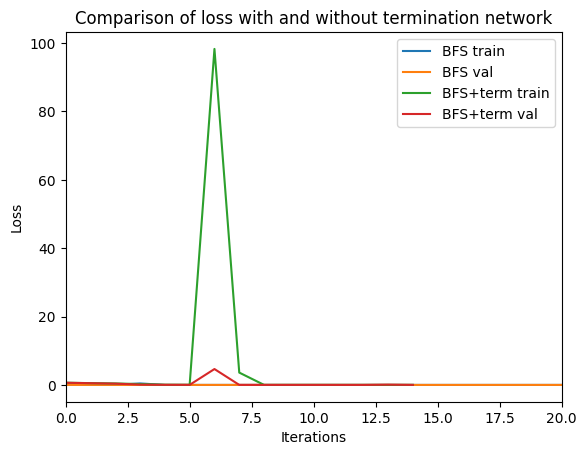

In [82]:
BFS_train_loss = read_lists_from_files('/data/results/max_only_BFS_train_loss_v1.txt')
BFS_val_loss = read_lists_from_files('/data/results/max_only_BFS_val_loss_v1.txt')
BFS_with_term_train_loss = read_lists_from_files('/data/results/BFS_with_term_train_loss_v3.txt')
BFS_with_term_val_loss = read_lists_from_files('/data/results/max_BFS_with_term_val_loss_v3.txt')

fig, ax = plt.subplots()
ax.plot(BFS_train_loss, label='BFS train')
ax.plot(BFS_val_loss, '-', label='BFS val')
ax.plot(BFS_with_term_train_loss, label='BFS+term train')
ax.plot(BFS_with_term_val_loss, '-', label='BFS+term val')
ax.set_title('Comparison of loss with and without termination network')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend()
ax.set_xlim(0, 20)
plt.show()


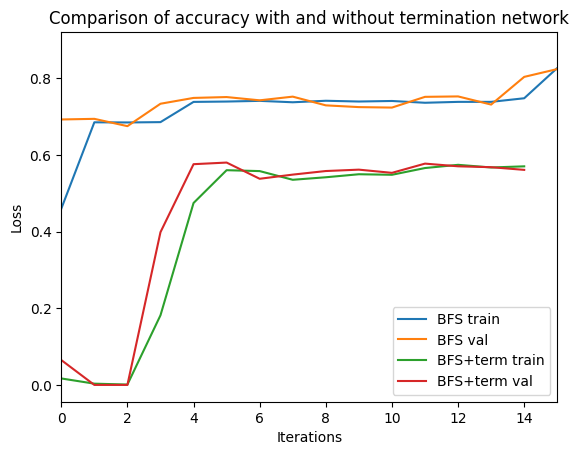

In [84]:
BFS_train_acc = read_lists_from_files('/data/results/max_only_BFS_train_acc_v1.txt')
BFS_val_acc = read_lists_from_files('/data/results/max_only_BFS_val_acc_v1.txt')
BFS_with_term_train_acc = read_lists_from_files('/data/results/BFS_with_term_train_acc_v3.txt')
BFS_with_term_val_acc = read_lists_from_files('/data/results/max_BFS_with_term_val_acc_v3.txt')

fig, ax = plt.subplots()
ax.plot(BFS_train_acc, label='BFS train')
ax.plot(BFS_val_acc, '-', label='BFS val')
ax.plot(BFS_with_term_train_acc, label='BFS+term train')
ax.plot(BFS_with_term_val_acc, '-', label='BFS+term val')
ax.set_title('Comparison of accuracy with and without termination network')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend()
ax.set_xlim(0, 15)
plt.show()
